In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from scipy.stats import logistic
# from scipy.special import logit

import torch
# import torch.nn.functional as F
# from torchvision import transforms
# from torch.utils.data import Dataset
# from torch.cuda.amp import autocast, GradScaler

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Train with GPU support.")
else:
    device = torch.device('cpu')
    print("No GPU found, train with CPU support.")

import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt

# own utils
from utils.graph import *
from utils.tram_models import *
from utils.tram_model_helpers import *
from utils.tram_data import *
from utils.loss_continous import *
from utils.sampling_tram_data import *



# import ipywidgets as widgets
# from IPython.display import display, clear_output


Train with GPU support.


# 1. Experiments and Paths

In [2]:
experiment_name = "conf_dict_test"   ## <--- set experiment name
seed=42
np.random.seed(seed)

LOG_DIR="/home/bule/TramDag/dev_experiment_logs"
EXPERIMENT_DIR = os.path.join(LOG_DIR, experiment_name)
DATA_PATH = EXPERIMENT_DIR # <----------- change to different source if needed
CONF_DICT_PATH = os.path.join(EXPERIMENT_DIR, f"configuration.json")

os.makedirs(EXPERIMENT_DIR,exist_ok=True)
# check if configration dict already exists if not create:

if os.path.exists(CONF_DICT_PATH):
    configuration_dict=load_configuration_dict(CONF_DICT_PATH)
    print(f"Loaded existing configuration from {CONF_DICT_PATH}")
else:
    configuration_dict=create_and_write_new_configuration_dict(experiment_name,CONF_DICT_PATH,EXPERIMENT_DIR,DATA_PATH,LOG_DIR)
    print(f"Created new configuration file at {CONF_DICT_PATH}")

Loaded existing configuration from /home/bule/TramDag/dev_experiment_logs/conf_dict_test/configuration.json


# 2.  Data

In [3]:
from scipy.special import logit
from mpl_toolkits.mplot3d import Axes3D


# Define the functions used in the DGP
def f1(x1, x2):
    return np.sin(np.pi * x1) * np.cos(np.pi * x2)

def f2(x3, x4):
    return np.exp(-((x3 - 1)**2 + (x4 - 1)**2))

def f3(x5, x6):
    return (x5 * x6) / (1 + x5**2 + x6**2)

def dgp_continuous_interactions(n_obs=10_000, seed=42):
    np.random.seed(seed)

    # Independent variables
    x1 = np.random.uniform(0, 2, size=n_obs)
    x2 = np.random.uniform(0, 2, size=n_obs)
    x3 = np.random.uniform(0, 2, size=n_obs)
    x4 = np.random.uniform(0, 2, size=n_obs)
    x5 = np.random.normal(0, 2, size=n_obs)
    x6 = np.random.uniform(0, 2, size=n_obs)
    x7 = np.random.normal(0, 2, size=n_obs)

    # Response variable with interactions
    y = f1(x1, x2) + f2(x3, x4) + f3(x5, x6) + 1.5 * x7

    df = pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3, 'x4': x4, 'x5': x5, 'x6': x6, 'x7': x7, 'x8': y})
    return df


EXP_DATA_PATH=os.path.join(DATA_PATH, f"{experiment_name}.csv")
if not os.path.exists(EXP_DATA_PATH):
    df = dgp_continuous_interactions()

    print(df.head())
    df.to_csv(EXP_DATA_PATH, index=False)
else:
    df = pd.read_csv(EXP_DATA_PATH)
    print(f"Loaded data from {EXP_DATA_PATH}")


data_type= {'x1':'cont','x2':'cont','x3':'cont','x4':'cont','x5':'cont','x6':'cont','x7':'cont','x8':'cont'} # cont:continous, ord:ordinal, oher:everything else than images

write_data_type_to_configuration(data_type, CONF_DICT_PATH)


Loaded data from /home/bule/TramDag/dev_experiment_logs/conf_dict_test/conf_dict_test.csv
Configuration updated successfully.


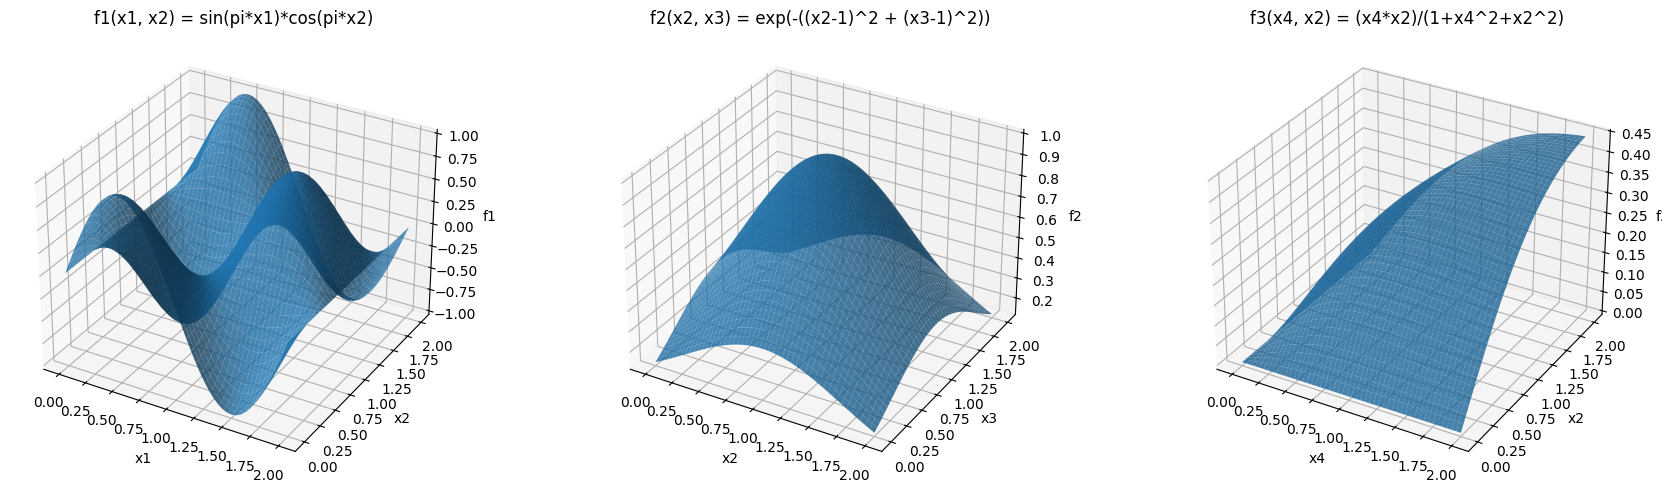

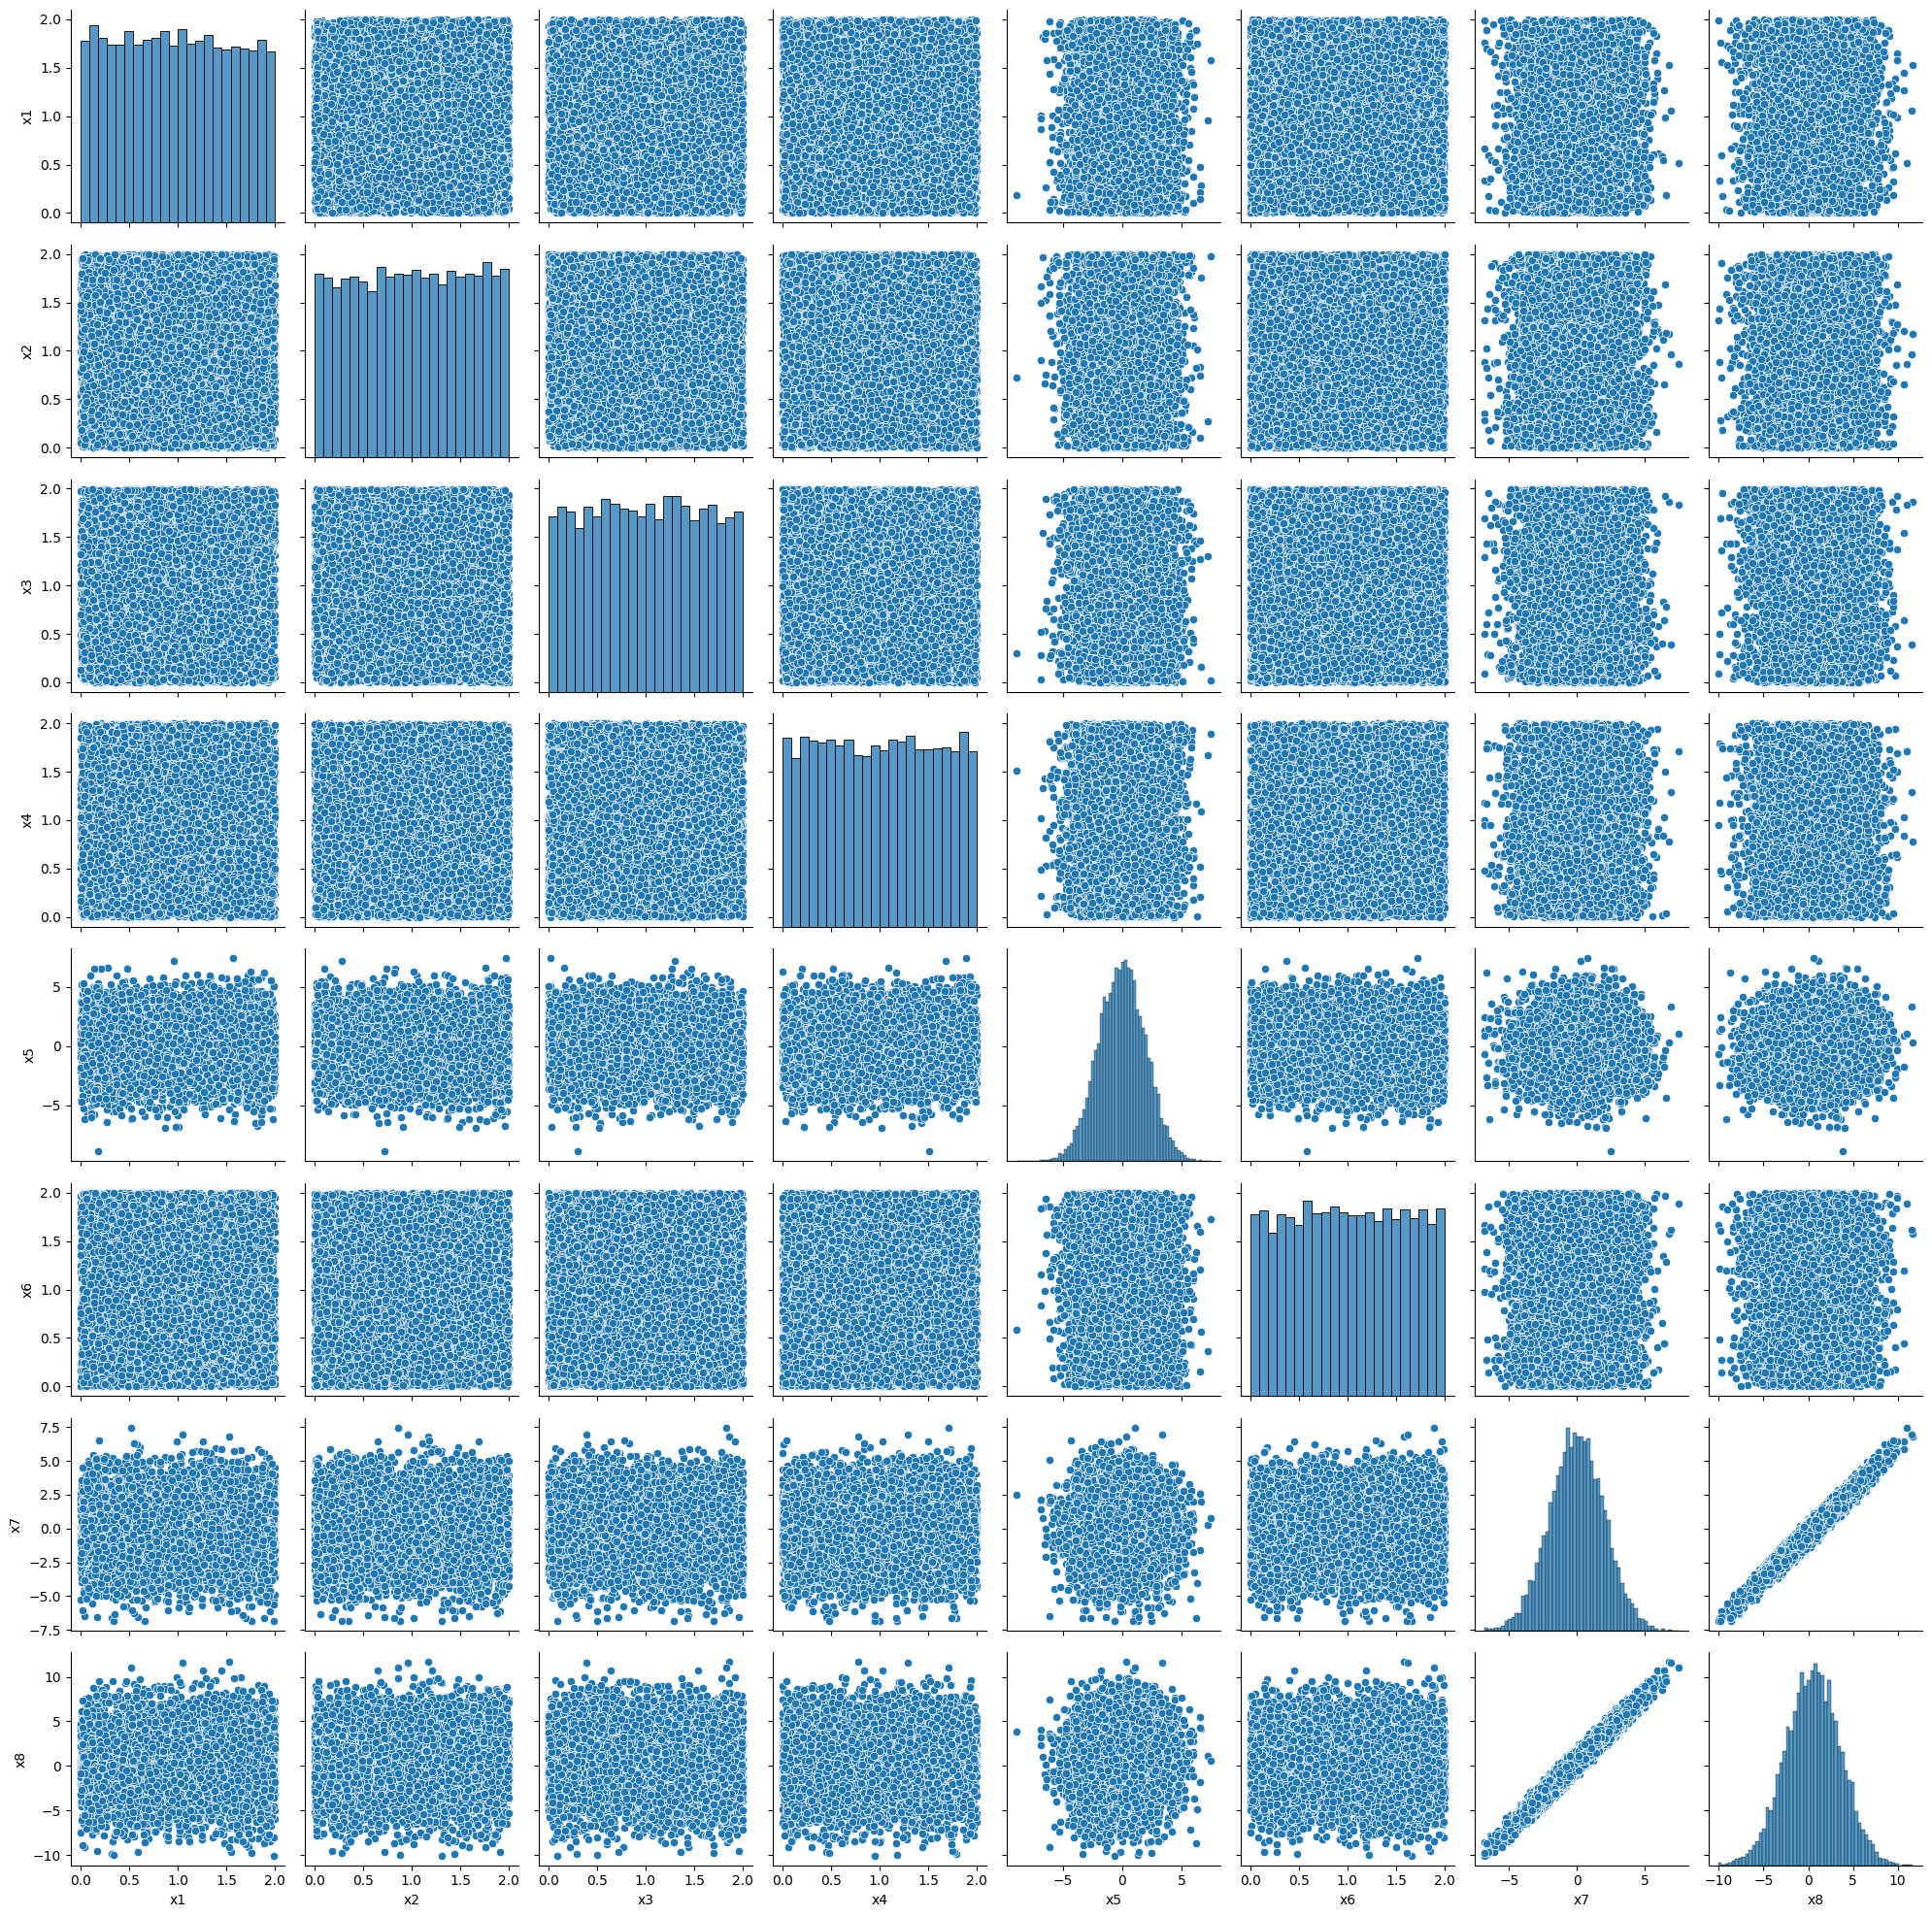

In [4]:

# Visualize the 3 interaction functions
fig = plt.figure(figsize=(18, 5))

# f1(x1, x2)
ax = fig.add_subplot(131, projection='3d')
x = np.linspace(0, 2, 50)
y = np.linspace(0, 2, 50)
X, Y = np.meshgrid(x, y)
Z = f1(X, Y)
ax.plot_surface(X, Y, Z, alpha=0.8)
ax.set_title("f1(x1, x2) = sin(pi*x1)*cos(pi*x2)")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("f1")

# f2(x2, x3)
ax = fig.add_subplot(132, projection='3d')
X, Y = np.meshgrid(x, y)
Z = f2(X, Y)
ax.plot_surface(X, Y, Z, alpha=0.8)
ax.set_title("f2(x2, x3) = exp(-((x2-1)^2 + (x3-1)^2))")
ax.set_xlabel("x2")
ax.set_ylabel("x3")
ax.set_zlabel("f2")

# f3(x4, x2)
ax = fig.add_subplot(133, projection='3d')
X, Y = np.meshgrid(x, y)
Z = f3(X, Y)
ax.plot_surface(X, Y, Z, alpha=0.8)
ax.set_title("f3(x4, x2) = (x4*x2)/(1+x4^2+x2^2)")
ax.set_xlabel("x4")
ax.set_ylabel("x2")
ax.set_zlabel("f3")

plt.tight_layout()
plt.show()


sns.pairplot(df)
plt.suptitle("", y=1.02)
plt.tight_layout()
plt.show()

## 2.1 train test split

In [5]:
# 1. Split the data
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# 2. Compute quantiles from training data
quantiles = train_df.quantile([0.05, 0.95])
min_vals = quantiles.loc[0.05]
max_vals = quantiles.loc[0.95]

# 3. Normalize all sets using training quantiles
def normalize_with_quantiles(df, min_vals, max_vals):
    return (df - min_vals) / (max_vals - min_vals)

# train_df = normalize_with_quantiles(train_df, min_vals, max_vals)
# val_df = normalize_with_quantiles(val_df, min_vals, max_vals)
# test_df = normalize_with_quantiles(test_df, min_vals, max_vals)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")

Train size: 8000, Validation size: 1000, Test size: 1000


# 3. Define graph Structure

- define graph and which shift and intercept terms to use


/home/bule/TramDag/utils/graph.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


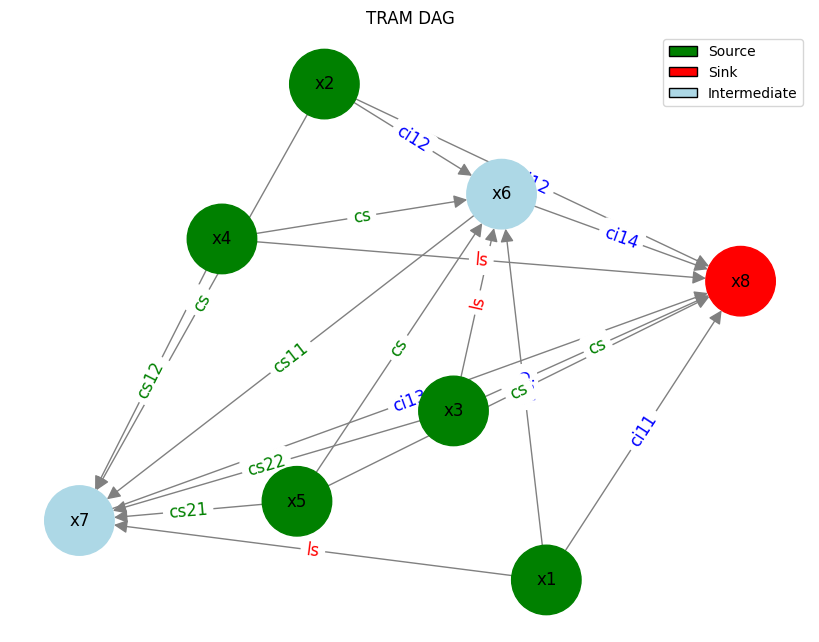

In [6]:
interactive_adj_matrix(CONF_DICT_PATH,seed=10)

# 4. Configuration for the Models

- all SI and LS model are generated outmatically since these are shallow NN's
- CI and CS have to be defined by the User and can be Passed for each model, -> generate default networks which are generated automaitcally

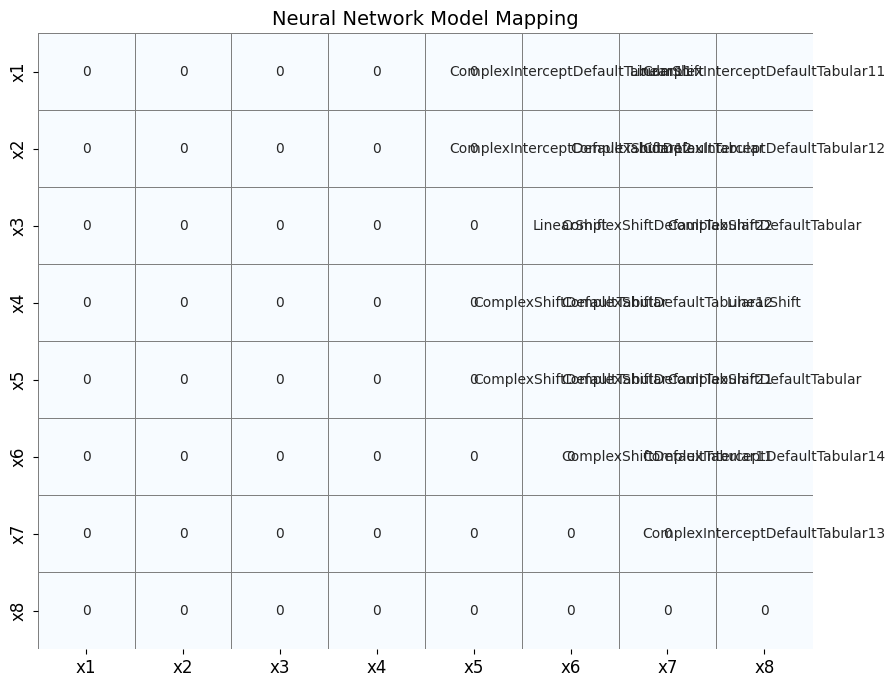

In [7]:
interactive_nn_names_matrix(CONF_DICT_PATH, seed=5)

In [8]:
write_nodes_information_to_configuration(CONF_DICT_PATH, min_vals, max_vals)

Configuration updated successfully.


/home/bule/TramDag/utils/graph.py:589: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nodes_dict[node]['min']=min_vals[i].tolist()
/home/bule/TramDag/utils/graph.py:590: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nodes_dict[node]['max']=max_vals[i].tolist()


In [9]:
# read configuration dict
configuration_dict = load_configuration_dict(CONF_DICT_PATH)
configuration_dict

{'date_of_creation': '2025-07-01 04:54:33',
 'experiment_name': 'conf_dict_test',
 'PATHS': {'DATA_PATH': '/home/bule/TramDag/dev_experiment_logs/conf_dict_test',
  'LOG_DIR': '/home/bule/TramDag/dev_experiment_logs',
  'EXPERIMENT_DIR': '/home/bule/TramDag/dev_experiment_logs/conf_dict_test'},
 'data_type': {'x1': 'cont',
  'x2': 'cont',
  'x3': 'cont',
  'x4': 'cont',
  'x5': 'cont',
  'x6': 'cont',
  'x7': 'cont',
  'x8': 'cont'},
 'adj_matrix': [['0', '0', '0', '0', '0', 'ci11', 'ls', 'ci11'],
  ['0', '0', '0', '0', '0', 'ci12', 'cs', 'ci12'],
  ['0', '0', '0', '0', '0', 'ls', 'cs22', 'cs'],
  ['0', '0', '0', '0', '0', 'cs', 'cs12', 'ls'],
  ['0', '0', '0', '0', '0', 'cs', 'cs21', 'cs'],
  ['0', '0', '0', '0', '0', '0', 'cs11', 'ci14'],
  ['0', '0', '0', '0', '0', '0', '0', 'ci13'],
  ['0', '0', '0', '0', '0', '0', '0', '0']],
 'model_names': [['0',
   '0',
   '0',
   '0',
   '0',
   'ComplexInterceptDefaultTabular11',
   'LinearShift',
   'ComplexInterceptDefaultTabular11'],
  ['0

In [10]:
DEV_TRAINING=True
train_list=['x1','x2','x3','x4','x5','x6','x7','x8']#['x2']#'x1','x2']#,'x3']#['x1']#['x1','x2','x3']#,#,['x1','x2','x3'] # <-  set the nodes which have to be trained , useful if further training is required else lsit all vars

batch_size = 512#4112
epochs = 4# <- if you want a higher numbe rof epochs, set the number higher and it loads the old model and starts from there
learning_rate=0.01
use_scheduler =  False

In [11]:
# For each NODE 
target_nodes = configuration_dict['nodes']

for node in target_nodes:
    
    print(f'\n----*----------*-------------*--------------- Node: {node} ------------*-----------------*-------------------*--')
    ########################## 0. Skip nodes ###############################
    if node not in train_list:# Skip if node is not in train_list
        print(f"Skipping node {node} as it's not in the training list.")
        continue
    if (target_nodes[node]['node_type'] == 'source') and (target_nodes[node]['node_type'] == 'other'):# Skip unsupported types
        print(f"Node type : other , is not supported yet")
        continue

    ########################## 1. Setup Paths ###############################
    NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
    os.makedirs(NODE_DIR, exist_ok=True)
    MODEL_PATH, LAST_MODEL_PATH, TRAIN_HIST_PATH, VAL_HIST_PATH = model_train_val_paths(NODE_DIR)

    ########################## 2. Create Model ##############################
    tram_model = get_fully_specified_tram_model(node, target_nodes, verbose=True).to(device)

    _, ordered_transformation_terms_in_h, _=ordered_parents(node, target_nodes)
    
    
    ########################## 3. Create Dataloaders ########################
    train_loader, val_loader = get_dataloader(node, target_nodes, train_df, val_df, batch_size=batch_size, verbose=True)

    ########################## 4. Load Model & History ######################
    if os.path.exists(MODEL_PATH) and os.path.exists(TRAIN_HIST_PATH) and os.path.exists(VAL_HIST_PATH):
        print("Existing model found. Loading weights and history...")
        tram_model.load_state_dict(torch.load(MODEL_PATH))

        with open(TRAIN_HIST_PATH, 'r') as f:
            train_loss_hist = json.load(f)
        with open(VAL_HIST_PATH, 'r') as f:
            val_loss_hist = json.load(f)

        start_epoch = len(train_loss_hist)
        best_val_loss = min(val_loss_hist)
        print(f"Continuing training from epoch {start_epoch}...")
    else:
        print("No existing model found. Starting fresh...")
        train_loss_hist, val_loss_hist = [], []
        start_epoch = 0
        best_val_loss = float('inf')

    # Skip if already trained
    if start_epoch >= epochs:
        print(f"Node {node} already trained for {epochs} epochs. Skipping.")
        continue

    ########################## 5. Optimizer & Scheduler ######################.
    
    optimizer =torch.optim.Adam(tram_model.parameters(), lr=learning_rate)
    
    if use_scheduler:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
        #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr=1e-3, total_steps=epochs * len(train_loader),pct_start=0.1, anneal_strategy="cos"       # pick your sweet-spot
    else:
        scheduler = None

    ########################## 6. Min/Max Tensor #############################
    min_vals = torch.tensor(target_nodes[node]['min'], dtype=torch.float32).to(device)
    max_vals = torch.tensor(target_nodes[node]['max'], dtype=torch.float32).to(device)
    min_max = torch.stack([min_vals, max_vals], dim=0)

    ########################## 7. Training Loop ##############################

    if DEV_TRAINING:
        train_val_loop(
            start_epoch,
            epochs,
            tram_model,
            train_loader,
            val_loader,
            train_loss_hist,
            val_loss_hist,
            best_val_loss,
            device,
            optimizer,
            use_scheduler,
            scheduler,
            min_max,
            NODE_DIR,
            ordered_transformation_terms_in_h,
            save_linear_shifts=True,
            verbose=1
        )


----*----------*-------------*--------------- Node: x1 ------------*-----------------*-------------------*--
Source → SimpleIntercept only
>>>>>>>>>>>>  source node --> x in dataloader contains just 1s 
Existing model found. Loading weights and history...
Continuing training from epoch 4...
Node x1 already trained for 4 epochs. Skipping.

----*----------*-------------*--------------- Node: x2 ------------*-----------------*-------------------*--
Source → SimpleIntercept only
>>>>>>>>>>>>  source node --> x in dataloader contains just 1s 
Existing model found. Loading weights and history...
Continuing training from epoch 4...
Node x2 already trained for 4 epochs. Skipping.

----*----------*-------------*--------------- Node: x3 ------------*-----------------*-------------------*--
Source → SimpleIntercept only
>>>>>>>>>>>>  source node --> x in dataloader contains just 1s 
Existing model found. Loading weights and history...
Continuing training from epoch 4...
Node x3 already trained f

# 6 Inspect Training

## 6.1 Loss vs epochs

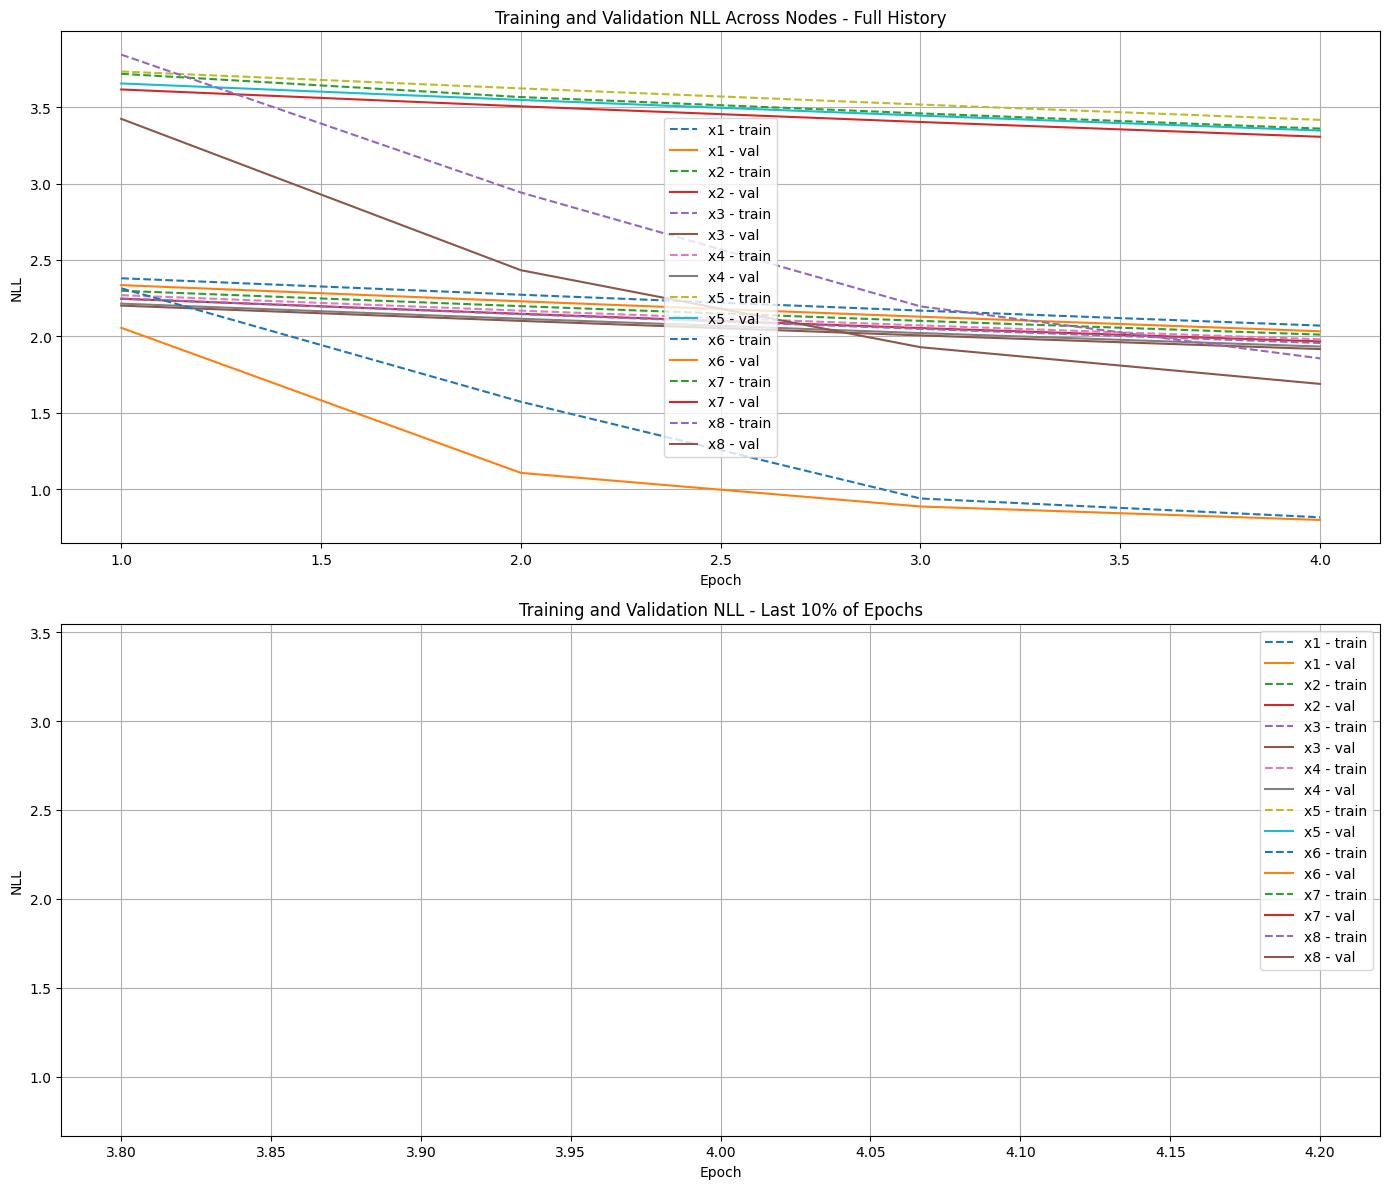

In [12]:
show_training_history(target_nodes,EXPERIMENT_DIR)

## 6.2 inspect transformation function for source nodes h()


----*----------*-------------*--------Inspect TRAFO Node: x1 ------------*-----------------*-------------------*--


h() for  x1:   0%|          | 0/1000 [00:00<?, ?it/s]


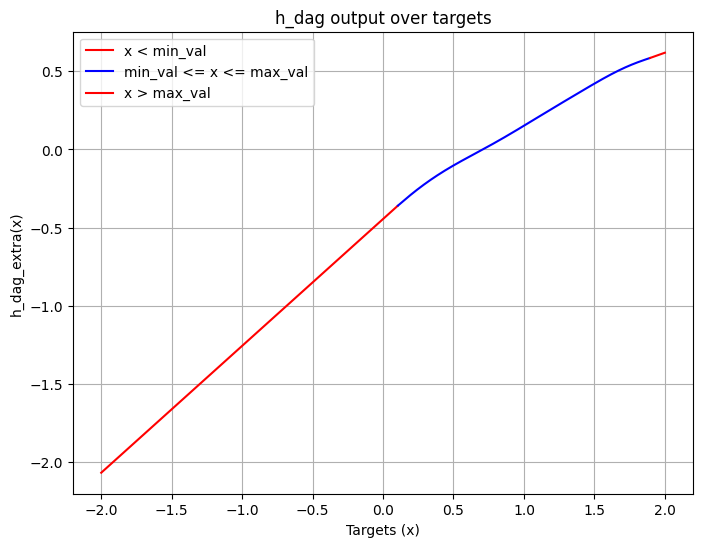


----*----------*-------------*--------Inspect TRAFO Node: x2 ------------*-----------------*-------------------*--


h() for  x2:   0%|          | 0/1000 [00:00<?, ?it/s]


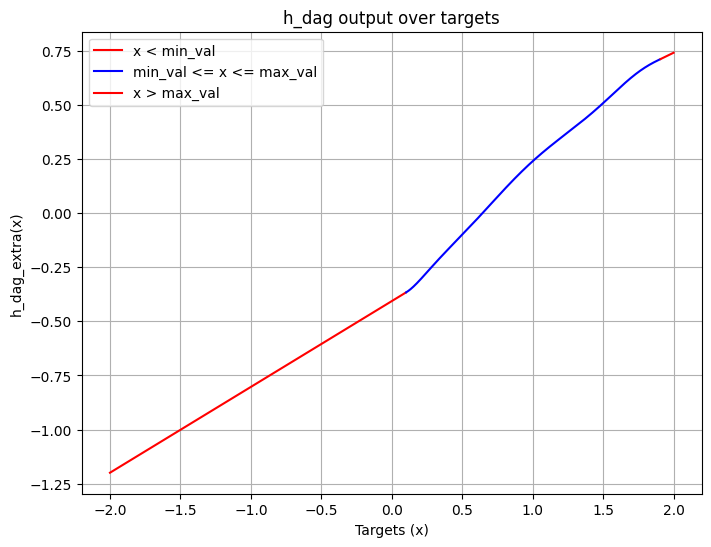


----*----------*-------------*--------Inspect TRAFO Node: x3 ------------*-----------------*-------------------*--


h() for  x3:   0%|          | 0/1000 [00:00<?, ?it/s]


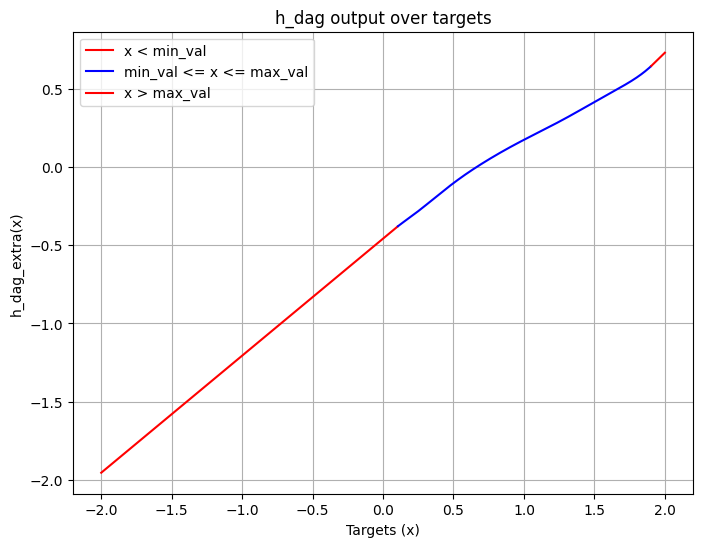


----*----------*-------------*--------Inspect TRAFO Node: x4 ------------*-----------------*-------------------*--


h() for  x4:   0%|          | 0/1000 [00:00<?, ?it/s]


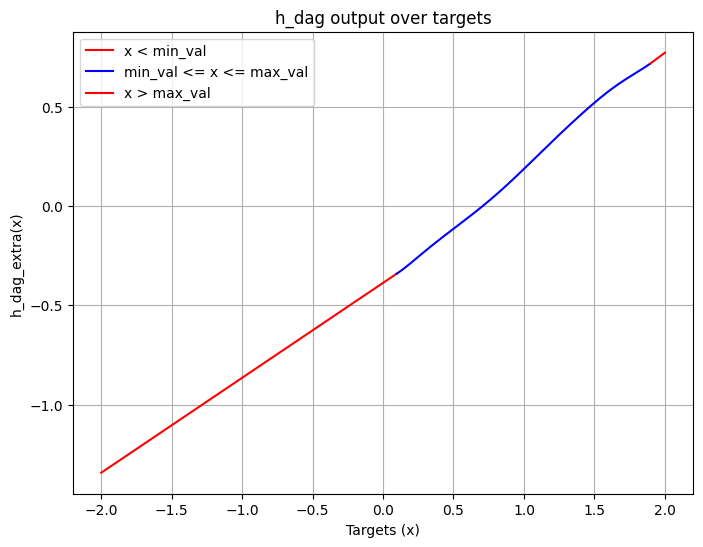


----*----------*-------------*--------Inspect TRAFO Node: x5 ------------*-----------------*-------------------*--


h() for  x5:   0%|          | 0/1000 [00:00<?, ?it/s]


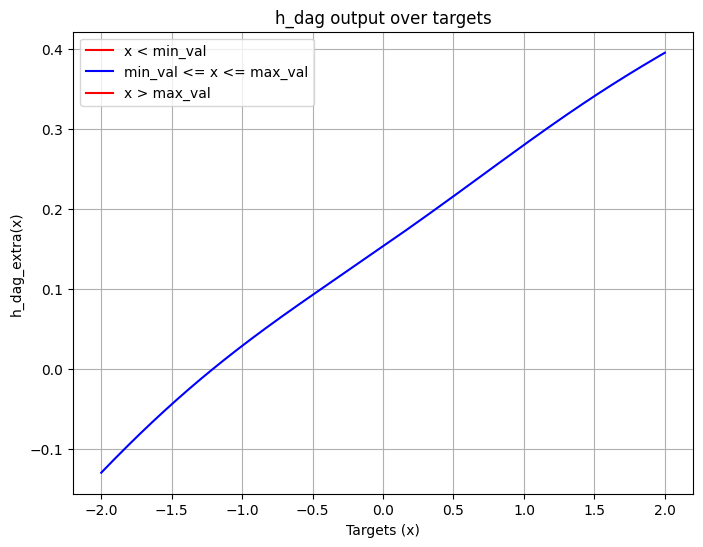


----*----------*-------------*--------Inspect TRAFO Node: x6 ------------*-----------------*-------------------*--
skipped.. since h does depend on parents and is different for every instance

----*----------*-------------*--------Inspect TRAFO Node: x7 ------------*-----------------*-------------------*--
skipped.. since h does depend on parents and is different for every instance

----*----------*-------------*--------Inspect TRAFO Node: x8 ------------*-----------------*-------------------*--
skipped.. since h does depend on parents and is different for every instance


In [13]:
show_hdag_for_source_nodes(target_nodes,EXPERIMENT_DIR,device=device,xmin_plot=-2,xmax_plot=2) # TODO for other nodes funciton


----*----------*-------------*--------h(data) should be standard logistic: x1 ------------*-----------------*-------------------*--


Val loader (x1): 100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


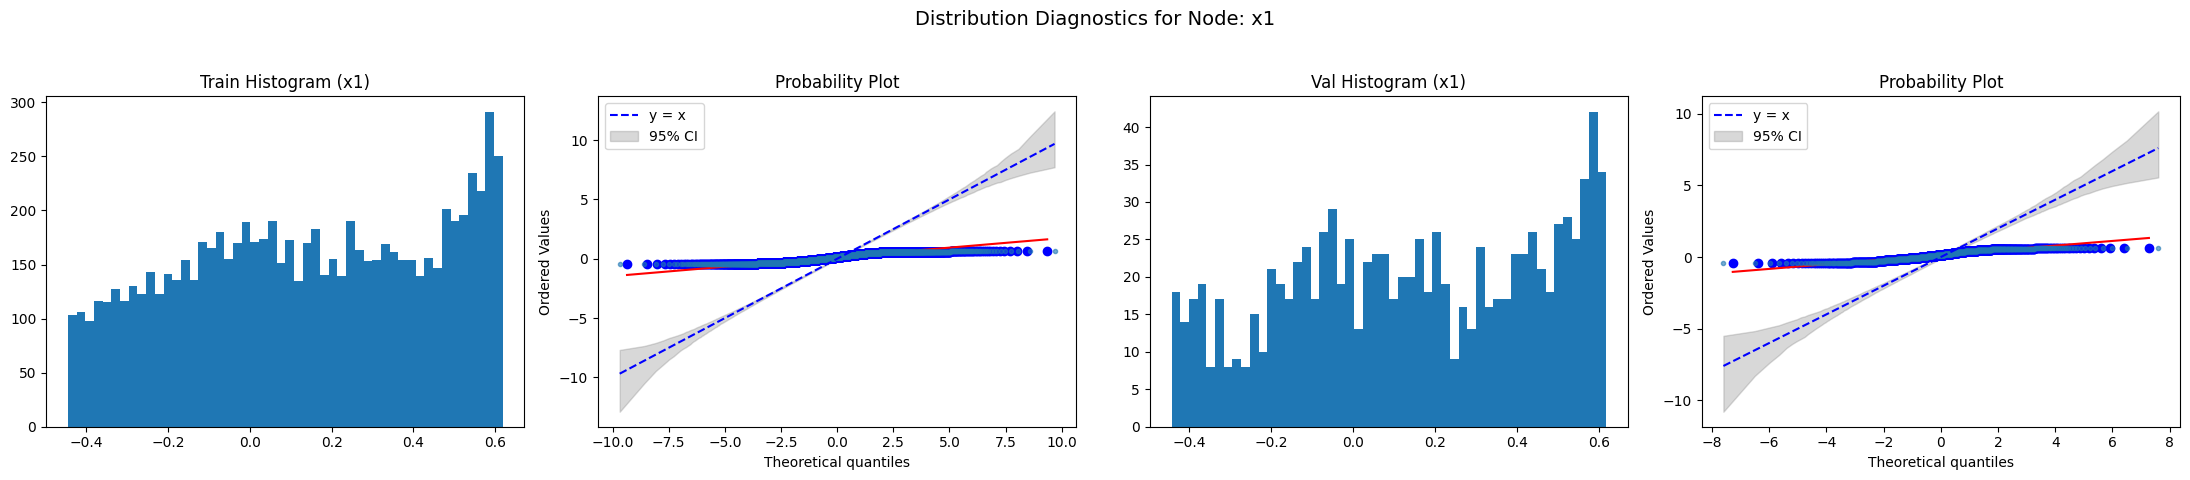


----*----------*-------------*--------h(data) should be standard logistic: x2 ------------*-----------------*-------------------*--


Val loader (x2): 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


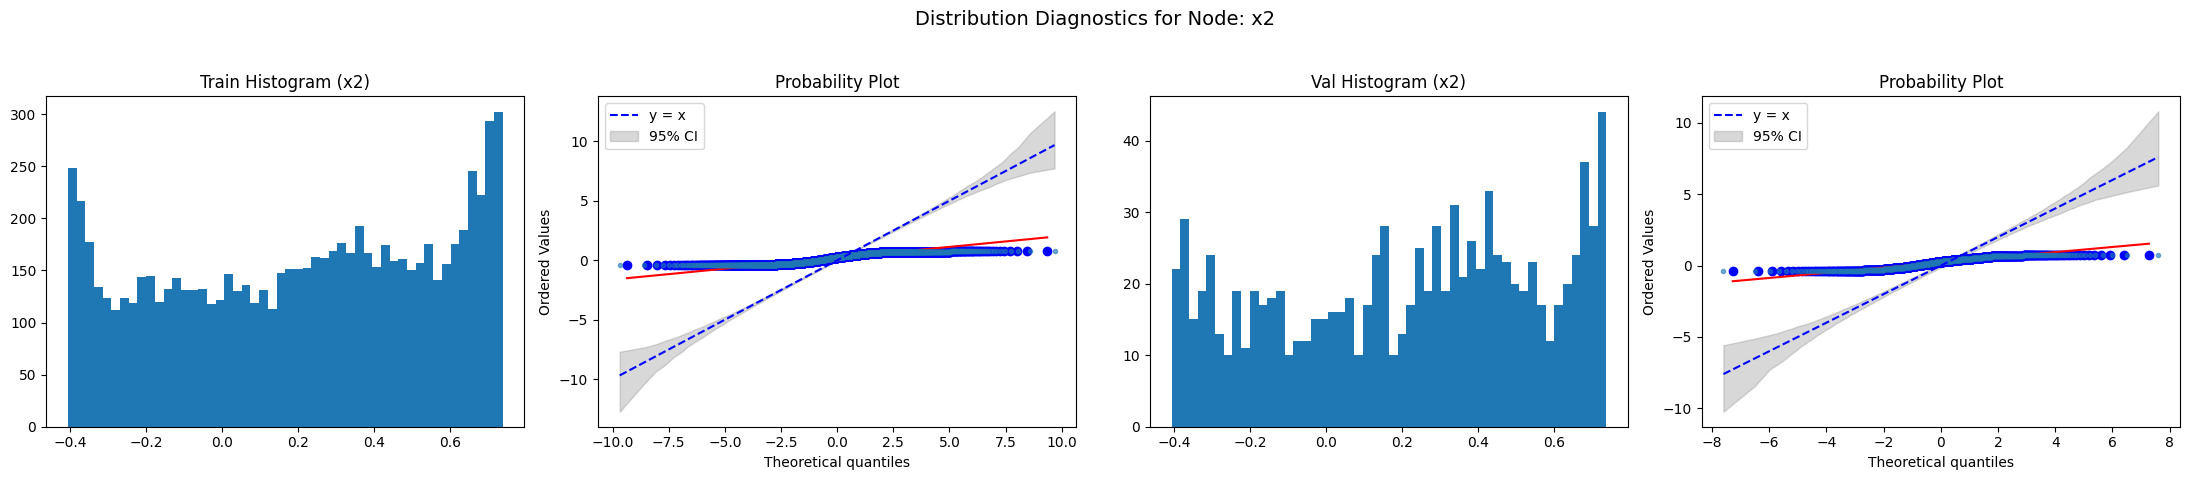


----*----------*-------------*--------h(data) should be standard logistic: x3 ------------*-----------------*-------------------*--


Val loader (x3): 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


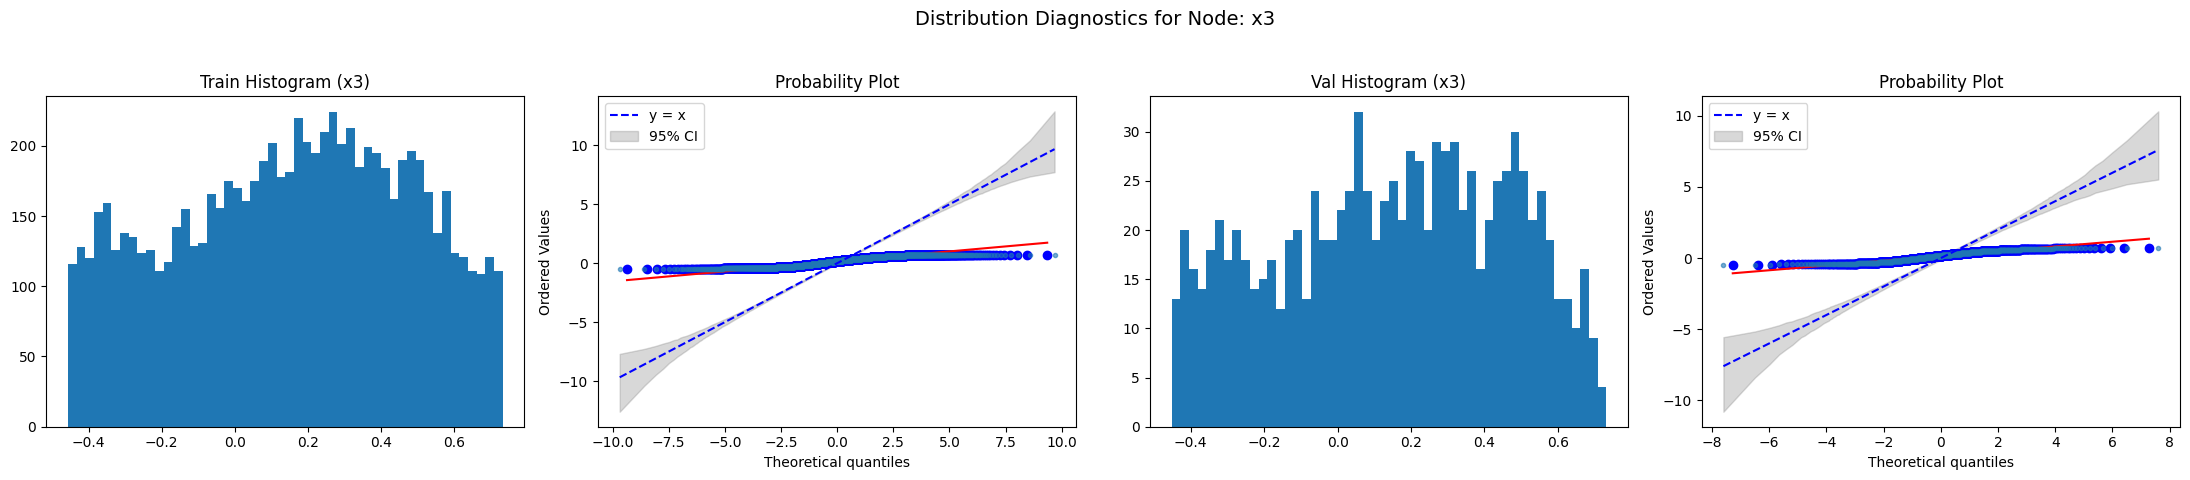


----*----------*-------------*--------h(data) should be standard logistic: x4 ------------*-----------------*-------------------*--


Val loader (x4): 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


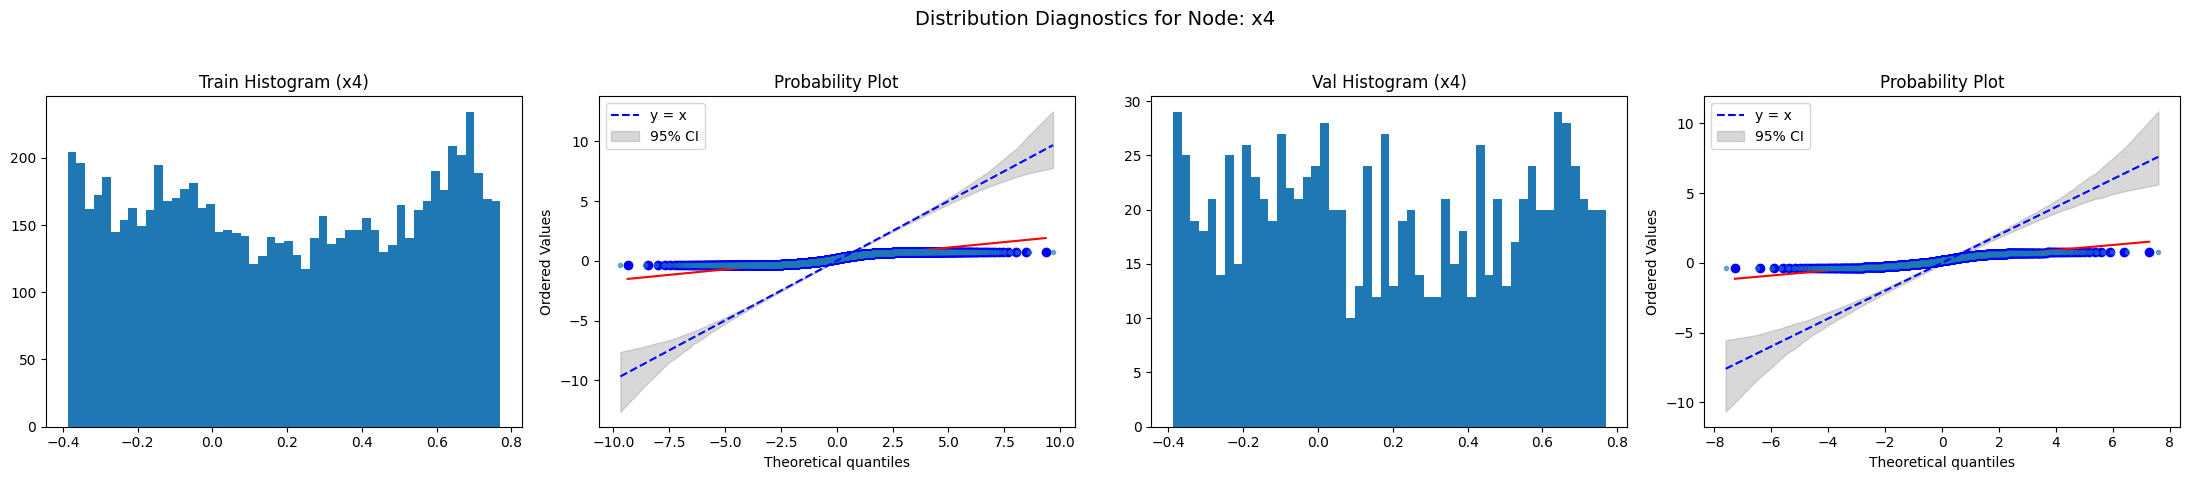


----*----------*-------------*--------h(data) should be standard logistic: x5 ------------*-----------------*-------------------*--


Val loader (x5): 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


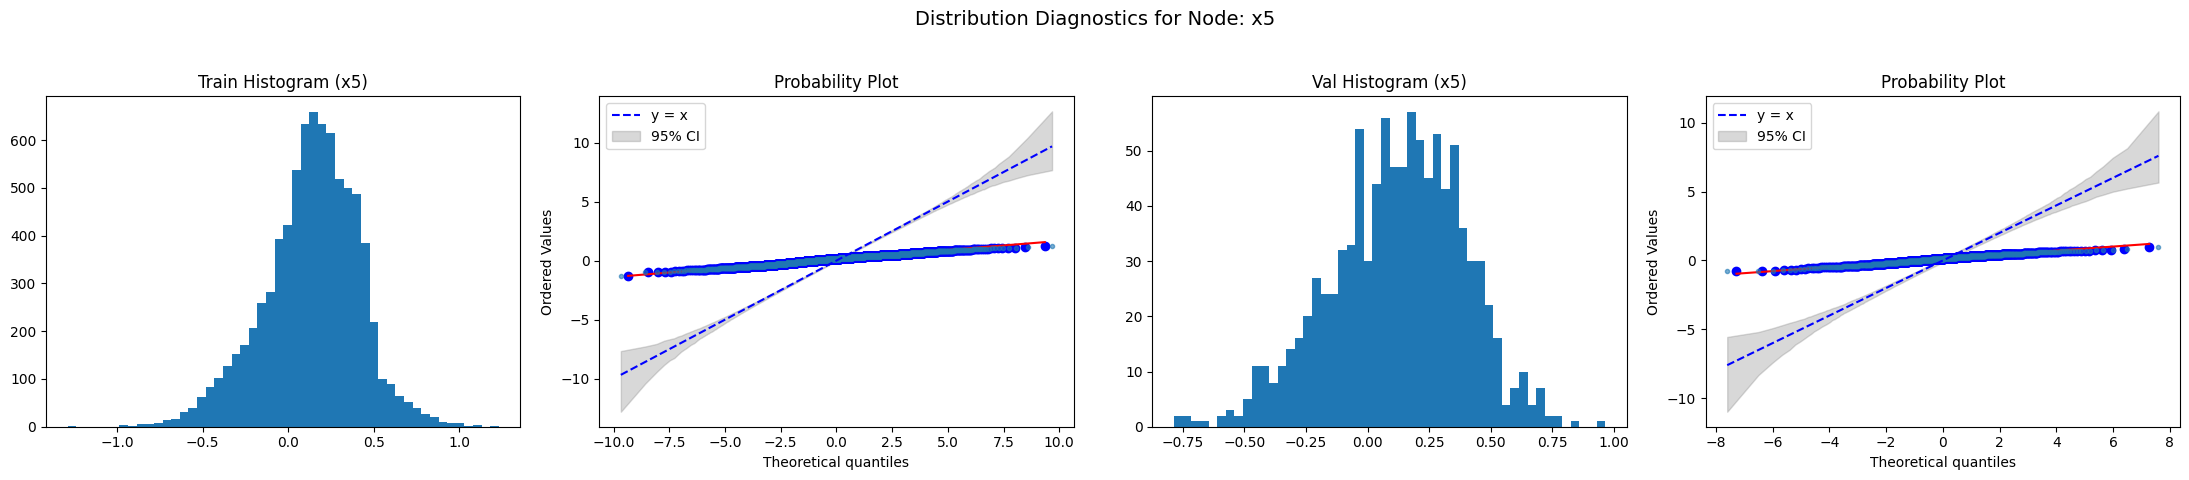


----*----------*-------------*--------h(data) should be standard logistic: x6 ------------*-----------------*-------------------*--


Val loader (x6): 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


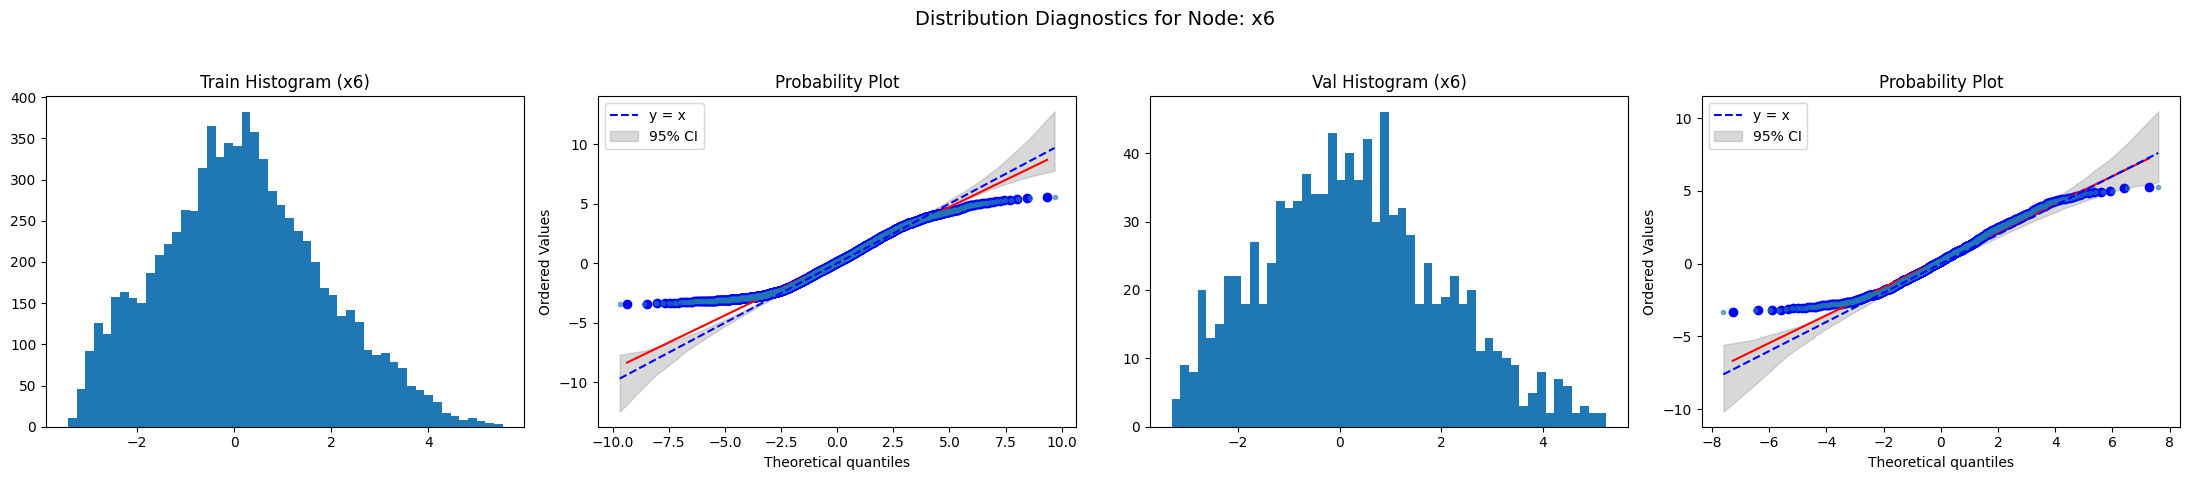


----*----------*-------------*--------h(data) should be standard logistic: x7 ------------*-----------------*-------------------*--


Val loader (x7): 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


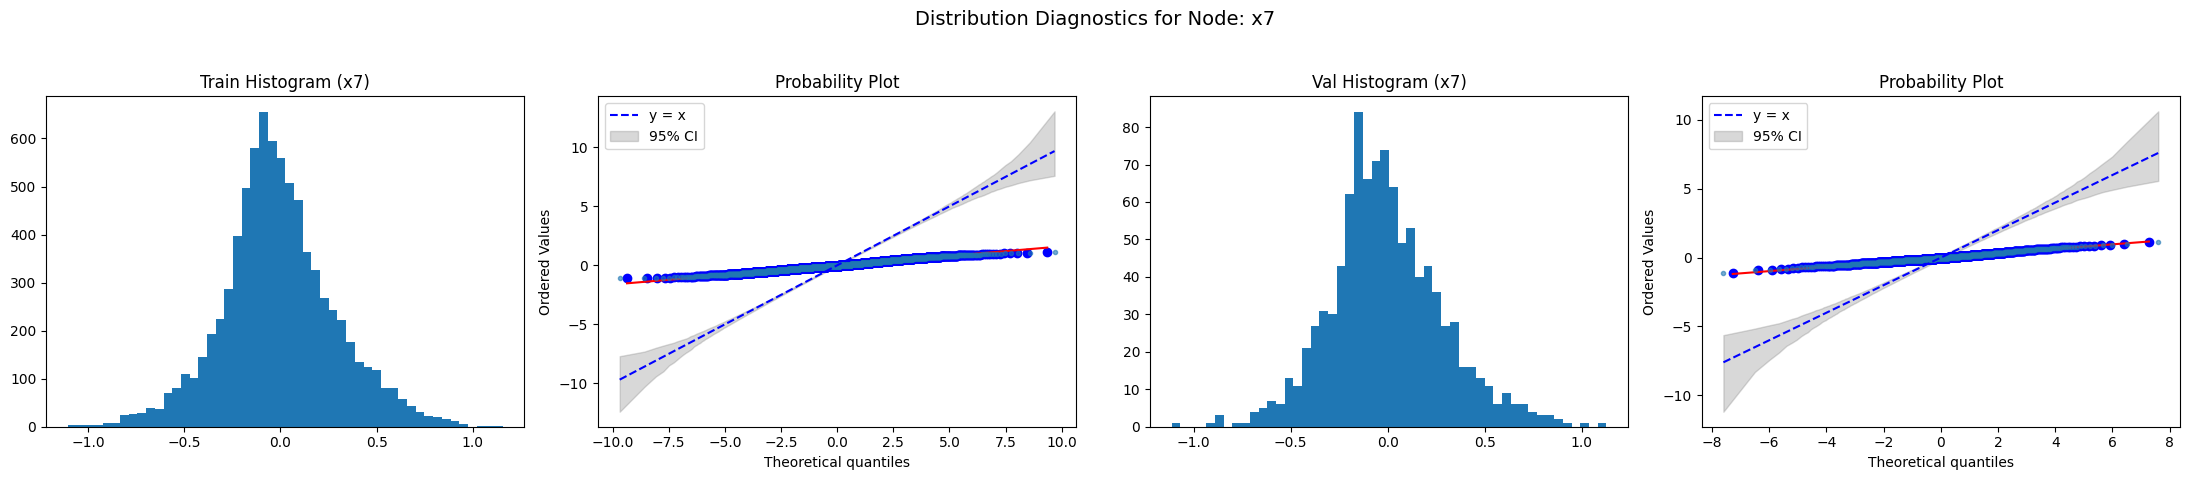


----*----------*-------------*--------h(data) should be standard logistic: x8 ------------*-----------------*-------------------*--


Val loader (x8): 100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


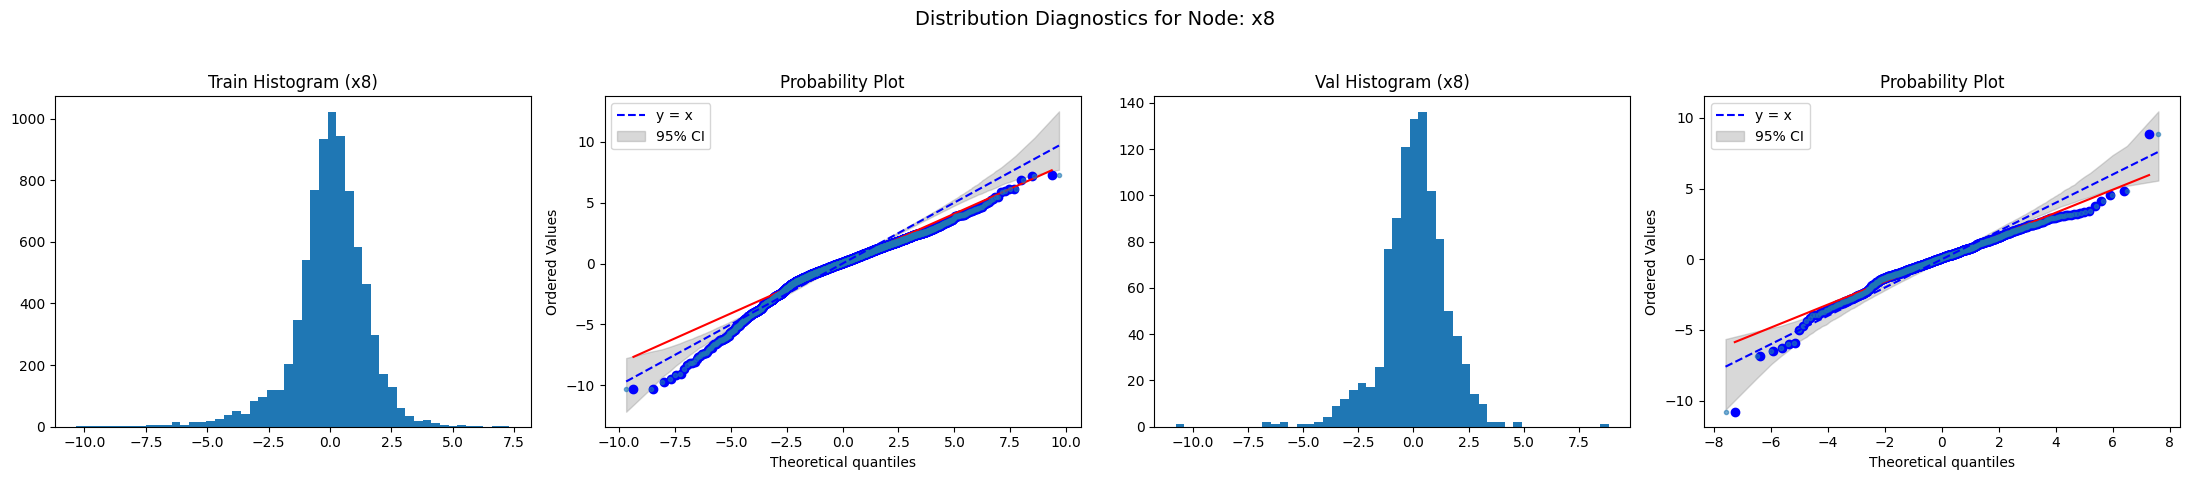

In [14]:
inspect_trafo_standart_logistic(target_nodes,EXPERIMENT_DIR,train_df,val_df,device,verbose=False)

### Coefficient estimates


---- check CS of x1 ----
Node type: source — skipping.

---- check CS of x2 ----
Node type: source — skipping.

---- check CS of x3 ----
Node type: source — skipping.

---- check CS of x4 ----
Node type: source — skipping.

---- check CS of x5 ----
Node type: source — skipping.

---- check CS of x6 ----

Module 0: ComplexShiftDefaultTabular
ComplexShiftDefaultTabular(
  (fc1): Linear(in_features=1, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=64, out_features=1, bias=False)
)
  expects input shape = (batch_size, 1)


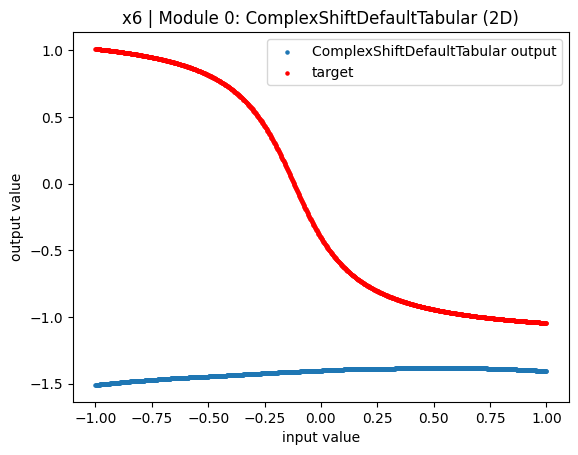


Module 1: ComplexShiftDefaultTabular
ComplexShiftDefaultTabular(
  (fc1): Linear(in_features=1, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=64, out_features=1, bias=False)
)
  expects input shape = (batch_size, 1)


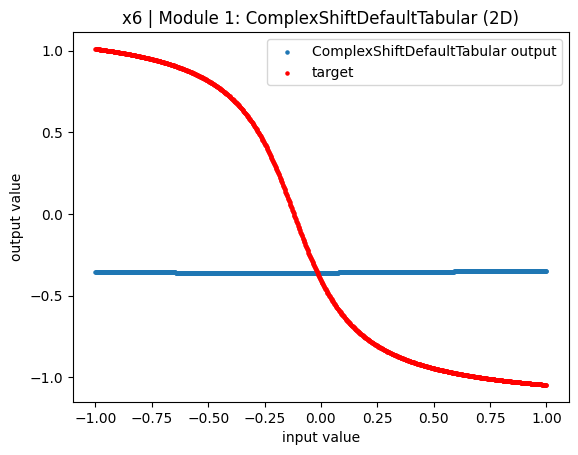


Module 2: LinearShift
LinearShift(
  (fc): Linear(in_features=1, out_features=1, bias=False)
)
  LinearShift weights:
tensor([[-0.1354]], device='cuda:0')

---- check CS of x7 ----

Module 0: ComplexShiftDefaultTabular
ComplexShiftDefaultTabular(
  (fc1): Linear(in_features=1, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=64, out_features=1, bias=False)
)
  expects input shape = (batch_size, 1)


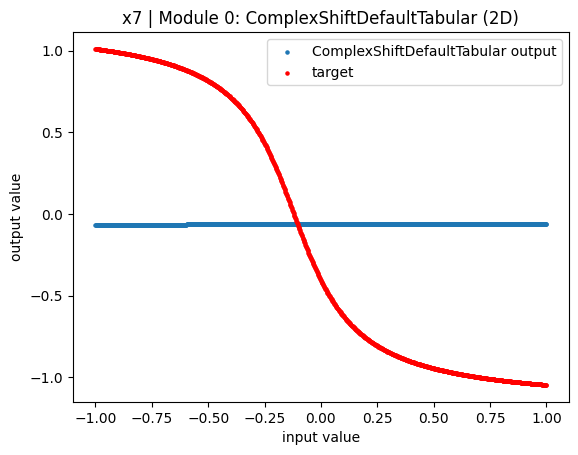


Module 1: ComplexShiftDefaultTabular
ComplexShiftDefaultTabular(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=64, out_features=1, bias=False)
)
  expects input shape = (batch_size, 2)


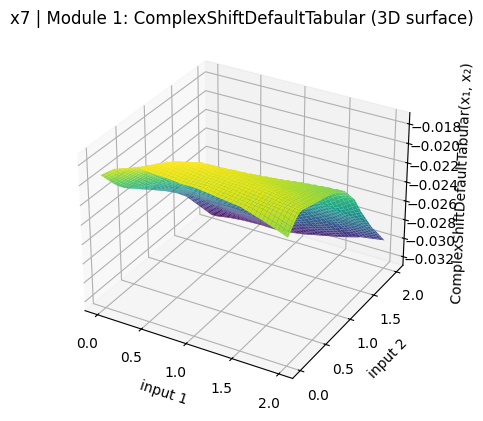


Module 2: ComplexShiftDefaultTabular
ComplexShiftDefaultTabular(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=64, out_features=1, bias=False)
)
  expects input shape = (batch_size, 2)


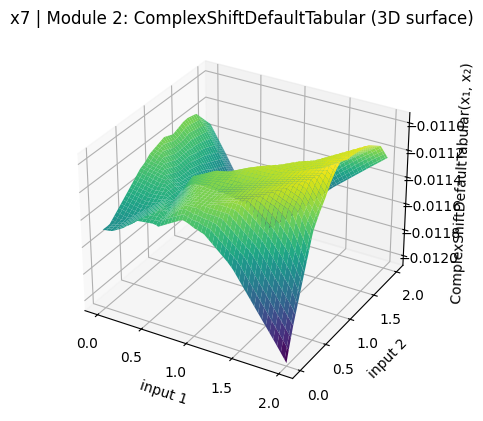


Module 3: LinearShift
LinearShift(
  (fc): Linear(in_features=1, out_features=1, bias=False)
)
  LinearShift weights:
tensor([[-0.0179]], device='cuda:0')

---- check CS of x8 ----

Module 0: ComplexShiftDefaultTabular
ComplexShiftDefaultTabular(
  (fc1): Linear(in_features=1, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=64, out_features=1, bias=False)
)
  expects input shape = (batch_size, 1)


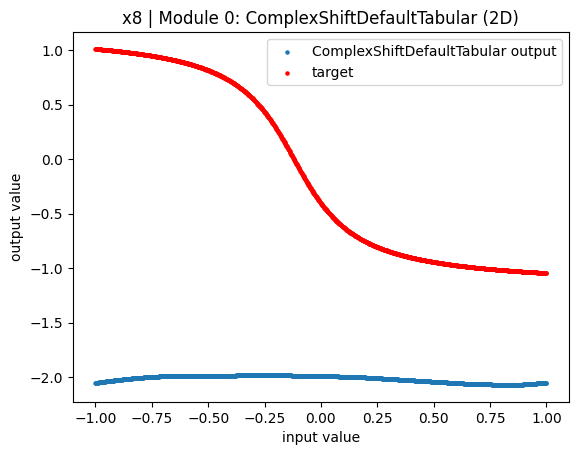


Module 1: ComplexShiftDefaultTabular
ComplexShiftDefaultTabular(
  (fc1): Linear(in_features=1, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=64, out_features=1, bias=False)
)
  expects input shape = (batch_size, 1)


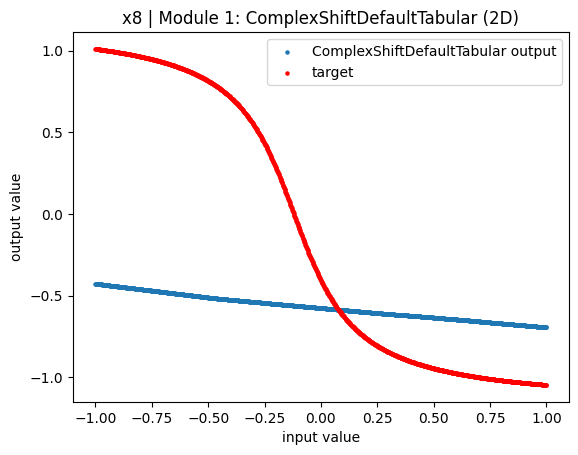


Module 2: LinearShift
LinearShift(
  (fc): Linear(in_features=1, out_features=1, bias=False)
)
  LinearShift weights:
tensor([[-0.2454]], device='cuda:0')


In [15]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # enable 3D plotting

# --- Your existing setup ---
verbose    = False
batch_size = 4112
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# this x is only for overlaying your target curve in 2D plots
x1d = torch.linspace(-1, 1, steps=1000).unsqueeze(1).to(device)  # (1000, 1)
def f(x):
    return 0.75 * np.arctan(5 * (x + 0.12))

for node in target_nodes:
    print(f"\n---- check CS of {node} ----")
    if target_nodes[node]['node_type'] == 'source':
        print("Node type: source — skipping.")
        continue

    # load your model
    NODE_DIR   = os.path.join(EXPERIMENT_DIR, node)
    model_path = os.path.join(NODE_DIR, "best_model.pt")
    tram_model = get_fully_specified_tram_model(node, target_nodes, verbose=verbose).to(device)
    tram_model.load_state_dict(torch.load(model_path))
    tram_model.eval()


    for i, module in enumerate(tram_model.nn_shift):
        name = module.__class__.__name__
        print(f"\nModule {i}: {name}")
        print(module)

        if name == 'LinearShift':
            print("  LinearShift weights:")
            print(module.fc.weight.data)
            continue

        # read wanted input dims
        in_feats = module.fc1.in_features
        print(f"  expects input shape = (batch_size, {in_feats})")

        # 2-input case → 3D surface plot
        if in_feats == 2:
            N = 100
            a = torch.linspace(-0, 2, steps=N, device=device)
            b = torch.linspace(-0, 2, steps=N, device=device)
            A, B = torch.meshgrid(a, b, indexing='ij')       # both (N, N)
            grid = torch.stack([A, B], dim=-1).view(-1, 2)   # (N*N, 2)

            with torch.no_grad():
                Y = module(grid).view(N, N).cpu().numpy()    # back to (N, N)

            A_np = A.cpu().numpy()
            B_np = B.cpu().numpy()

            fig = plt.figure()
            ax  = fig.add_subplot(111, projection='3d')
            ax.plot_surface(A_np, B_np, Y, cmap='viridis', edgecolor='none')
            ax.set_xlabel('input 1')
            ax.set_ylabel('input 2')
            ax.set_zlabel(f'{name}(x₁, x₂)')
            ax.set_title(f"{node} | Module {i}: {name} (3D surface)")
            plt.show()

        # 1-input case → 2D scatter
        else:
            N = 1000
            lin = torch.linspace(-1, 1, steps=N, device=device)
            dummy = lin.unsqueeze(1).repeat(1, in_feats)      # (N, in_feats)

            with torch.no_grad():
                y = module(dummy).squeeze().cpu().numpy()

            plt.figure()
            plt.scatter(dummy[:, 0].cpu().numpy(), y, s=5, label=f"{name} output")
            # overlay target
            plt.scatter(x1d.cpu().numpy(), -f(x1d.cpu().numpy()), c="red", s=5, label="target")
            plt.xlabel("input value")
            plt.ylabel("output value")
            plt.title(f"{node} | Module {i}: {name} (2D)")
            plt.legend()
            plt.show()


# 7. Sample from Graph

In [18]:
def sample_full_dag_chandru(target_nodes_dict,
                            EXPERIMENT_DIR,
                            device,
                            do_interventions={},
                            n= 10_000,
                            batch_size = 32,
                            delete_all_previously_sampled=True,
                            verbose=True):
    """
    Samples data for all nodes in a DAG defined by `conf_dict`, ensuring that each node's
    parents are sampled before the node itself. Supports interventions on any subset of nodes.

    Parameters
    ----------
    conf_dict : dict
        Dictionary defining the DAG. Each key is a node name, and each value is a config
        dict that includes at least:
            - 'node_type': str, either 'source' or other
            - 'parents': list of parent node names
            - 'min': float, minimum allowed value for the node
            - 'max': float, maximum allowed value for the node

    EXPERIMENT_DIR : str
        Base directory where all per-node directories are located.

    device : torch.device
        The device to run computations on (e.g., 'cuda' or 'cpu').

    do_interventions : dict, optional
        A dictionary specifying interventions for some nodes. Keys are node names (str),
        values are floats. For each intervened node, the specified value is used as the
        sampled value for all samples, and the model is bypassed. e.g. {'x1':1.0}

    n : int, optional
        Number of samples to draw for each node (default is 10_000).

    batch_size : int, optional
        Batch size for model evaluation during sampling (default is 32).

    delete_all_previously_sampled : bool, optional
        If True, removes previously sampled data before starting (default is True).

    verbose : bool, optional
        If True, prints debug/status information (default is True).

    Notes
    -----
    - The function ensures that nodes are only sampled after their parents.
    - Nodes with `node_type='source'` are treated as having no parents.
    - If a node is in `do_interventions`, `sampled_chandrupatla.pt` and a dummy `latents.pt`
      are created, enabling downstream nodes to proceed.
    - Sampling is done using a vectorized root-finding method (Chandrupatla's algorithm).
    """


    # delete the previolusly sampled data
    if delete_all_previously_sampled:
        delete_all_samplings(target_nodes_dict, EXPERIMENT_DIR)
    
    
    # repeat process until all nodes are sampled
    processed_nodes=[] # stack
    while set(processed_nodes) != set(target_nodes_dict.keys()): 
        for node in target_nodes_dict: # for each node in the conf dict
            if node in processed_nodes:
                if verbose :
                    print('node is already  in sampled list')
                continue
            
            _, ordered_transformation_terms_in_h, _=ordered_parents(node, target_nodes_dict)

            
            print(f'\n----*----------*-------------*--------Sample Node: {node} ------------*-----------------*-------------------*--') 
            
            ## 1. Paths 
            NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
            SAMPLING_DIR = os.path.join(NODE_DIR, 'sampling')
            os.makedirs(SAMPLING_DIR, exist_ok=True)
            
            
            ## 2. Check if sampled and latents already exist 
            if check_sampled_and_latents(NODE_DIR, rootfinder='chandrupatla', verbose=verbose):
                processed_nodes.append(node)
                continue
            
            ## 3. logic to make sure parents are always sampled first
            skipping_node = False
            if target_nodes_dict[node]['node_type'] != 'source':
                for parent in target_nodes_dict[node]['parents']:
                    if not check_sampled_and_latents(os.path.join(EXPERIMENT_DIR, parent), rootfinder='chandrupatla', verbose=verbose):
                        skipping_node = True
                        break
                    
            if skipping_node:
                print(f"Skipping {node} as parent {parent} is not sampled yet.")
                continue
            
            
            
            ## INTERVENTION, if node is to be intervened on , data is just saved
            if node in do_interventions.keys():
                intervention_value = do_interventions[node]
                intervention_vals = torch.full((n,), intervention_value)
                sampled_path = os.path.join(SAMPLING_DIR, "sampled_chandrupatla.pt")
                torch.save(intervention_vals, sampled_path)
                ### dummy latents jsut for the check , not needed
                dummy_latents = torch.full((n,), float('nan'))  
                latents_path = os.path.join(SAMPLING_DIR, "latents.pt")
                torch.save(dummy_latents, latents_path)
                processed_nodes.append(node)
                
            ## no intervention, based on the sampled data from the parents though the latents for each node the observational distribution is generated    
            else:
                ### sampling latents
                latent_sample = torch.tensor(logistic.rvs(size=n), dtype=torch.float32).to(device)
                #latent_sample = truncated_logistic_sample(n=n, low=0, high=1, device=device)
                
                if verbose:
                    print("-- sampled latents")
                
                ### load modelweights
                model_path = os.path.join(NODE_DIR, "best_model.pt")
                tram_model = get_fully_specified_tram_model(node, target_nodes_dict, verbose=verbose).to(device)
                tram_model.load_state_dict(torch.load(model_path))
                
                if verbose:
                    print("-- loaded modelweights")
                    
                dataset = SamplingDataset(node=node, EXPERIMENT_DIR=EXPERIMENT_DIR, rootfinder='chandrupatla', number_of_samples=n, conf_dict=target_nodes_dict, transform=None)
                sample_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
                
                output_list = []
                with torch.no_grad():
                    for x in tqdm(sample_loader, desc=f"h() for samples in  {node}"):
                        x = [xi.to(device) for xi in x]
                        
                        print(f"x {x}")
                        int_input, shift_list = preprocess_inputs(x,ordered_transformation_terms_in_h.values(), device=device)
                        
                    
                        if int_input is not None:
                            print(f"int_input {int_input.shape}")
                        if shift_list is not None:
                            print(f"shift_list {[s.shape for s in shift_list]}") 
                        
                        print([t.shape for t in x])
                        
                        model_outputs = tram_model(int_input=int_input, shift_input=shift_list)
                        
                        print(f"model_outputs {model_outputs}")
                        
                        output_list.append(model_outputs)
                        
                if target_nodes_dict[node]['node_type'] == 'source':
                    if verbose:
                        print("source node, Defaults to SI and 1 as inputs")
                    theta_single = output_list[0]['int_out'][0]
                    theta_single = transform_intercepts_continous(theta_single)
                    thetas_expanded = theta_single.repeat(n, 1)
                    shifts = torch.zeros(n, device=device)
                else:
                    if verbose:
                        print("node has parents, previously sampled data is loaded for each pa(node)")
                    y_pred = merge_outputs(output_list, skip_nan=True)
                    shifts = y_pred['shift_out']
                    if shifts is None:
                        print("shift_out was None; defaulting to zeros.")
                        shifts = torch.zeros(n, device=device)
                    thetas = y_pred['int_out']
                    thetas_expanded = transform_intercepts_continous(thetas).squeeze()
                    shifts = shifts.squeeze()
                
                
                
                low = torch.full((n,), -1e5, device=device)
                high = torch.full((n,), 1e5, device=device)
                min_vals = torch.tensor(target_nodes_dict[node]['min'], dtype=torch.float32).to(device)
                max_vals = torch.tensor(target_nodes_dict[node]['max'], dtype=torch.float32).to(device)
                min_max = torch.stack([min_vals, max_vals], dim=0)
                
                ## Root finder using Chandrupatla's method
                def f_vectorized(targets):
                    return vectorized_object_function(
                        thetas_expanded,
                        targets,
                        shifts,
                        latent_sample,
                        k_min=min_max[0],
                        k_max=min_max[1]
                    )
                    
                root = chandrupatla_root_finder(
                    f_vectorized,
                    low,
                    high,
                    max_iter=10_000,
                    tol=1e-9
                )
                
                ## Saving
                sampled_path = os.path.join(SAMPLING_DIR, "sampled_chandrupatla.pt")
                latents_path = os.path.join(SAMPLING_DIR, "latents.pt")
                
                if torch.isnan(root).any():
                    print(f'Caution! Sampling for {node} consists of NaNs')
                    
                torch.save(root, sampled_path)
                torch.save(latent_sample, latents_path)
                
                processed_nodes.append(node)

In [20]:
sample_full_dag_chandru(target_nodes,
                            EXPERIMENT_DIR,
                            device,
                            n= 100,
                            batch_size = 2,
                            delete_all_previously_sampled=True,
                            verbose=True)     

# TODO Fix bug with x6 sampling , training works, sampling has issue 

Deleted directory: /home/bule/TramDag/dev_experiment_logs/conf_dict_test/x1/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/conf_dict_test/x2/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/conf_dict_test/x3/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/conf_dict_test/x4/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/conf_dict_test/x5/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/conf_dict_test/x6/sampling
Directory does not exist: /home/bule/TramDag/dev_experiment_logs/conf_dict_test/x7/sampling
Directory does not exist: /home/bule/TramDag/dev_experiment_logs/conf_dict_test/x8/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
Root or latent files not found in /home/bule/TramDag/dev_experiment_logs/conf_dict_test/x1/sampling
-- sampled latents
Source → SimpleIntercept only
-- loaded modelweights


h() for samples in  x1: 100%|██████████| 50/50 [00:00<00:00, 398.13it/s]


x [tensor([[1.],
        [1.]], device='cuda:0')]
int_input torch.Size([2, 1, 1])
[torch.Size([2, 1])]
model_outputs {'int_out': tensor([[[-0.3047,  1.1876,  1.3377,  0.3412,  1.1767,  0.1995, -0.3507,
           0.4404,  0.5071,  0.5237,  0.8353,  1.0050, -0.0823,  0.6104,
           0.4550,  0.9400,  0.4663,  0.2579, -0.2721, -0.2582]],

        [[-0.3047,  1.1876,  1.3377,  0.3412,  1.1767,  0.1995, -0.3507,
           0.4404,  0.5071,  0.5237,  0.8353,  1.0050, -0.0823,  0.6104,
           0.4550,  0.9400,  0.4663,  0.2579, -0.2721, -0.2582]]],
       device='cuda:0'), 'shift_out': None}
x [tensor([[1.],
        [1.]], device='cuda:0')]
int_input torch.Size([2, 1, 1])
[torch.Size([2, 1])]
model_outputs {'int_out': tensor([[[-0.3047,  1.1876,  1.3377,  0.3412,  1.1767,  0.1995, -0.3507,
           0.4404,  0.5071,  0.5237,  0.8353,  1.0050, -0.0823,  0.6104,
           0.4550,  0.9400,  0.4663,  0.2579, -0.2721, -0.2582]],

        [[-0.3047,  1.1876,  1.3377,  0.3412,  1.1767,  0.1

Chandrupatla root finding: 100%|██████████| 10000/10000 [00:29<00:00, 334.94it/s]



----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
Root or latent files not found in /home/bule/TramDag/dev_experiment_logs/conf_dict_test/x2/sampling
-- sampled latents
Source → SimpleIntercept only
-- loaded modelweights


h() for samples in  x2: 100%|██████████| 50/50 [00:00<00:00, 561.51it/s]


x [tensor([[1.],
        [1.]], device='cuda:0')]
int_input torch.Size([2, 1, 1])
[torch.Size([2, 1])]
model_outputs {'int_out': tensor([[[-0.4249,  0.0406,  1.6192,  1.5814, -0.0461,  0.6104,  1.1971,
           1.4831,  1.4739,  0.8573,  0.1762,  0.8941,  0.0472, -0.2455,
           0.1185,  1.3796,  1.4103,  0.3857,  0.0834, -0.2635]],

        [[-0.4249,  0.0406,  1.6192,  1.5814, -0.0461,  0.6104,  1.1971,
           1.4831,  1.4739,  0.8573,  0.1762,  0.8941,  0.0472, -0.2455,
           0.1185,  1.3796,  1.4103,  0.3857,  0.0834, -0.2635]]],
       device='cuda:0'), 'shift_out': None}
x [tensor([[1.],
        [1.]], device='cuda:0')]
int_input torch.Size([2, 1, 1])
[torch.Size([2, 1])]
model_outputs {'int_out': tensor([[[-0.4249,  0.0406,  1.6192,  1.5814, -0.0461,  0.6104,  1.1971,
           1.4831,  1.4739,  0.8573,  0.1762,  0.8941,  0.0472, -0.2455,
           0.1185,  1.3796,  1.4103,  0.3857,  0.0834, -0.2635]],

        [[-0.4249,  0.0406,  1.6192,  1.5814, -0.0461,  0.6

Chandrupatla root finding: 100%|██████████| 10000/10000 [00:30<00:00, 332.75it/s]



----*----------*-------------*--------Sample Node: x3 ------------*-----------------*-------------------*--
Root or latent files not found in /home/bule/TramDag/dev_experiment_logs/conf_dict_test/x3/sampling
-- sampled latents
Source → SimpleIntercept only
-- loaded modelweights


h() for samples in  x3: 100%|██████████| 50/50 [00:00<00:00, 555.90it/s]


x [tensor([[1.],
        [1.]], device='cuda:0')]
int_input torch.Size([2, 1, 1])
[torch.Size([2, 1])]
model_outputs {'int_out': tensor([[[-0.6163,  1.0443,  0.3491,  1.5510,  1.4279,  1.0959,  0.3336,
          -0.2057,  1.2551,  0.6683, -0.1963, -0.2447,  0.0233,  0.6943,
           0.7904,  0.8997, -0.1977,  0.2779,  0.5626,  1.3461]],

        [[-0.6163,  1.0443,  0.3491,  1.5510,  1.4279,  1.0959,  0.3336,
          -0.2057,  1.2551,  0.6683, -0.1963, -0.2447,  0.0233,  0.6943,
           0.7904,  0.8997, -0.1977,  0.2779,  0.5626,  1.3461]]],
       device='cuda:0'), 'shift_out': None}
x [tensor([[1.],
        [1.]], device='cuda:0')]
int_input torch.Size([2, 1, 1])
[torch.Size([2, 1])]
model_outputs {'int_out': tensor([[[-0.6163,  1.0443,  0.3491,  1.5510,  1.4279,  1.0959,  0.3336,
          -0.2057,  1.2551,  0.6683, -0.1963, -0.2447,  0.0233,  0.6943,
           0.7904,  0.8997, -0.1977,  0.2779,  0.5626,  1.3461]],

        [[-0.6163,  1.0443,  0.3491,  1.5510,  1.4279,  1.0

Chandrupatla root finding: 100%|██████████| 10000/10000 [00:28<00:00, 348.74it/s]



----*----------*-------------*--------Sample Node: x4 ------------*-----------------*-------------------*--
Root or latent files not found in /home/bule/TramDag/dev_experiment_logs/conf_dict_test/x4/sampling
-- sampled latents
Source → SimpleIntercept only
-- loaded modelweights


h() for samples in  x4: 100%|██████████| 50/50 [00:00<00:00, 556.51it/s]


x [tensor([[1.],
        [1.]], device='cuda:0')]
int_input torch.Size([2, 1, 1])
[torch.Size([2, 1])]
model_outputs {'int_out': tensor([[[ 0.1127,  0.3086,  1.0164,  0.9146,  0.1935,  0.7711, -0.1682,
           1.2184, -0.1088,  1.3568,  1.1184,  1.5005,  0.8045,  0.0810,
           1.6262,  0.6125,  1.0264, -0.2863,  0.1090,  0.4653]],

        [[ 0.1127,  0.3086,  1.0164,  0.9146,  0.1935,  0.7711, -0.1682,
           1.2184, -0.1088,  1.3568,  1.1184,  1.5005,  0.8045,  0.0810,
           1.6262,  0.6125,  1.0264, -0.2863,  0.1090,  0.4653]]],
       device='cuda:0'), 'shift_out': None}
x [tensor([[1.],
        [1.]], device='cuda:0')]
int_input torch.Size([2, 1, 1])
[torch.Size([2, 1])]
model_outputs {'int_out': tensor([[[ 0.1127,  0.3086,  1.0164,  0.9146,  0.1935,  0.7711, -0.1682,
           1.2184, -0.1088,  1.3568,  1.1184,  1.5005,  0.8045,  0.0810,
           1.6262,  0.6125,  1.0264, -0.2863,  0.1090,  0.4653]],

        [[ 0.1127,  0.3086,  1.0164,  0.9146,  0.1935,  0.7

Chandrupatla root finding: 100%|██████████| 10000/10000 [00:29<00:00, 335.50it/s]



----*----------*-------------*--------Sample Node: x5 ------------*-----------------*-------------------*--
Root or latent files not found in /home/bule/TramDag/dev_experiment_logs/conf_dict_test/x5/sampling
-- sampled latents
Source → SimpleIntercept only
-- loaded modelweights


h() for samples in  x5: 100%|██████████| 50/50 [00:00<00:00, 536.12it/s]


x [tensor([[1.],
        [1.]], device='cuda:0')]
int_input torch.Size([2, 1, 1])
[torch.Size([2, 1])]
model_outputs {'int_out': tensor([[[-0.4758,  0.6469,  1.0891,  1.2335,  1.2757,  0.6305,  0.8919,
           0.3607, -0.0187, -0.3208,  0.2744,  0.0605,  1.1772,  0.3818,
           0.0498,  0.0508, -0.3230,  0.0317, -0.3050,  0.6873]],

        [[-0.4758,  0.6469,  1.0891,  1.2335,  1.2757,  0.6305,  0.8919,
           0.3607, -0.0187, -0.3208,  0.2744,  0.0605,  1.1772,  0.3818,
           0.0498,  0.0508, -0.3230,  0.0317, -0.3050,  0.6873]]],
       device='cuda:0'), 'shift_out': None}
x [tensor([[1.],
        [1.]], device='cuda:0')]
int_input torch.Size([2, 1, 1])
[torch.Size([2, 1])]
model_outputs {'int_out': tensor([[[-0.4758,  0.6469,  1.0891,  1.2335,  1.2757,  0.6305,  0.8919,
           0.3607, -0.0187, -0.3208,  0.2744,  0.0605,  1.1772,  0.3818,
           0.0498,  0.0508, -0.3230,  0.0317, -0.3050,  0.6873]],

        [[-0.4758,  0.6469,  1.0891,  1.2335,  1.2757,  0.6

Chandrupatla root finding: 100%|██████████| 10000/10000 [00:29<00:00, 335.54it/s]
/home/bule/TramDag/utils/sampling_tram_data.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_list.append(torch.tensor(tensor))  # ensure tensor type



----*----------*-------------*--------Sample Node: x6 ------------*-----------------*-------------------*--
Root or latent files not found in /home/bule/TramDag/dev_experiment_logs/conf_dict_test/x6/sampling
-- sampled latents
Constructed TRAM model: TramModel(
  (nn_int): ComplexInterceptDefaultTabular(
    (fc1): Linear(in_features=2, out_features=8, bias=True)
    (relu1): ReLU()
    (fc2): Linear(in_features=8, out_features=8, bias=True)
    (relu2): ReLU()
    (fc3): Linear(in_features=8, out_features=20, bias=False)
  )
  (nn_shift): ModuleList(
    (0-1): 2 x ComplexShiftDefaultTabular(
      (fc1): Linear(in_features=1, out_features=64, bias=True)
      (relu1): ReLU()
      (fc2): Linear(in_features=64, out_features=128, bias=True)
      (relu2): ReLU()
      (fc3): Linear(in_features=128, out_features=64, bias=True)
      (relu3): ReLU()
      (fc4): Linear(in_features=64, out_features=1, bias=False)
    )
    (2): LinearShift(
      (fc): Linear(in_features=1, out_features=

h() for samples in  x6:  32%|███▏      | 16/50 [00:00<00:00, 159.78it/s]

x [tensor([ 0.0369, -4.4431], device='cuda:0'), tensor([-1.1590,  2.0089], device='cuda:0'), tensor([-0.5940, -0.4214], device='cuda:0'), tensor([ 7.7003, -8.7565], device='cuda:0'), tensor([-3.0510, -0.2816], device='cuda:0')]
int_input torch.Size([2, 2])
shift_list [torch.Size([2, 1]), torch.Size([2, 1]), torch.Size([2, 1])]
[torch.Size([2]), torch.Size([2]), torch.Size([2]), torch.Size([2]), torch.Size([2])]
model_outputs {'int_out': tensor([[-3.6393,  6.8523,  4.8206,  3.6693,  4.2912,  4.3645,  2.4922,  2.7765,
          0.7594,  2.9318,  2.1911,  3.3577,  2.6096,  1.3400,  2.5078,  3.3693,
          4.0762,  5.8963,  6.7588,  6.6027],
        [-3.6776,  6.7953,  5.0911,  4.2849,  4.6283,  5.4711,  2.3622,  3.0083,
          0.8483,  2.8070,  1.9597,  3.4190,  2.5243,  1.8353,  3.2172,  3.1152,
          4.3538,  6.6300,  7.7916,  7.0575]], device='cuda:0'), 'shift_out': [tensor([[-1.4551],
        [-1.4399]], device='cuda:0'), tensor([[-0.6981],
        [-0.5422]], device='cuda:0

h() for samples in  x6:  64%|██████▍   | 32/50 [00:00<00:00, 157.53it/s]

model_outputs {'int_out': tensor([[-4.5819,  9.8908,  7.2322,  4.6604,  5.2227,  5.6549,  3.0923,  3.5409,
          0.6976,  4.7335,  2.6080,  4.9043,  4.0939,  2.1076,  2.9174,  4.8144,
          6.0373,  6.8257,  9.2911,  8.4364],
        [-6.6524, 13.6783,  9.3561,  6.7495,  7.6603,  8.0364,  4.3935,  5.1587,
          1.0510,  6.2493,  3.7436,  6.7242,  5.4569,  2.5668,  4.3862,  6.8887,
          8.2708, 10.3688, 12.6695, 12.3684]], device='cuda:0'), 'shift_out': [tensor([[-2.2251],
        [-1.6777]], device='cuda:0'), tensor([[-0.3596],
        [-1.9137]], device='cuda:0'), tensor([[ 0.1779],
        [-0.2115]], device='cuda:0')]}
x [tensor([-0.1304, -1.2004], device='cuda:0'), tensor([-0.4181,  5.4165], device='cuda:0'), tensor([1.9020, 1.0112], device='cuda:0'), tensor([ 3.4227, -6.2458], device='cuda:0'), tensor([-1.3864,  1.4711], device='cuda:0')]
int_input torch.Size([2, 2])
shift_list [torch.Size([2, 1]), torch.Size([2, 1]), torch.Size([2, 1])]
[torch.Size([2]), torch.Si

h() for samples in  x6: 100%|██████████| 50/50 [00:00<00:00, 158.13it/s]


x [tensor([-6.4524, -0.4069], device='cuda:0'), tensor([-1.2291,  1.7594], device='cuda:0'), tensor([0.2048, 3.7323], device='cuda:0'), tensor([-12.1511,  -2.8303], device='cuda:0'), tensor([ 1.9519, -0.6175], device='cuda:0')]
int_input torch.Size([2, 2])
shift_list [torch.Size([2, 1]), torch.Size([2, 1]), torch.Size([2, 1])]
[torch.Size([2]), torch.Size([2]), torch.Size([2]), torch.Size([2]), torch.Size([2])]
model_outputs {'int_out': tensor([[-1.6459,  3.0614,  2.7048,  1.6446,  1.9418,  2.1157,  1.2846,  1.1440,
          0.4467,  1.3757,  1.1235,  1.5185,  1.1852,  0.8830,  1.1115,  1.1661,
          1.7974,  2.6262,  3.5391,  2.8057],
        [-4.6737,  8.4582,  6.2290,  5.0594,  5.7913,  6.3434,  3.0675,  3.7693,
          1.0499,  3.5438,  2.7433,  4.1827,  3.1438,  1.9618,  3.8593,  4.0655,
          5.2314,  8.1272,  9.2607,  8.6546]], device='cuda:0'), 'shift_out': [tensor([[-1.3891],
        [-1.7479]], device='cuda:0'), tensor([[-0.6719],
        [-0.3781]], device='cuda:0

Chandrupatla root finding: 100%|██████████| 10000/10000 [00:28<00:00, 346.97it/s]



----*----------*-------------*--------Sample Node: x7 ------------*-----------------*-------------------*--
Root or latent files not found in /home/bule/TramDag/dev_experiment_logs/conf_dict_test/x7/sampling
-- sampled latents
Constructed TRAM model: TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
  (nn_shift): ModuleList(
    (0): ComplexShiftDefaultTabular(
      (fc1): Linear(in_features=1, out_features=64, bias=True)
      (relu1): ReLU()
      (fc2): Linear(in_features=64, out_features=128, bias=True)
      (relu2): ReLU()
      (fc3): Linear(in_features=128, out_features=64, bias=True)
      (relu3): ReLU()
      (fc4): Linear(in_features=64, out_features=1, bias=False)
    )
    (1-2): 2 x ComplexShiftDefaultTabular(
      (fc1): Linear(in_features=2, out_features=64, bias=True)
      (relu1): ReLU()
      (fc2): Linear(in_features=64, out_features=128, bias=True)
      (relu2): ReLU()
      (fc3): Linear(in_features=128,

h() for samples in  x7:  24%|██▍       | 12/50 [00:00<00:00, 112.86it/s]

x [tensor([1., 1.], device='cuda:0'), tensor([ 3.4895, -5.4462], device='cuda:0'), tensor([0.3857, 0.3275], device='cuda:0'), tensor([6.1602, 6.0103], device='cuda:0'), tensor([-15.5709, -14.1504], device='cuda:0'), tensor([-0.0384,  0.8429], device='cuda:0'), tensor([-1.8826, -1.0478], device='cuda:0')]
int_input torch.Size([2, 1])
shift_list [torch.Size([2, 1]), torch.Size([2, 2]), torch.Size([2, 2]), torch.Size([2, 1])]
[torch.Size([2]), torch.Size([2]), torch.Size([2]), torch.Size([2]), torch.Size([2]), torch.Size([2]), torch.Size([2])]
model_outputs {'int_out': tensor([[-0.6126,  0.7986,  1.0638,  0.6668,  1.0253,  0.2352,  0.2118, -0.3375,
         -0.2175,  0.2556,  0.4730,  0.2798,  0.2818, -0.3399,  1.5332,  1.1605,
          0.9534,  0.7009,  1.2813,  0.8162],
        [-0.6126,  0.7986,  1.0638,  0.6668,  1.0253,  0.2352,  0.2118, -0.3375,
         -0.2175,  0.2556,  0.4730,  0.2798,  0.2818, -0.3399,  1.5332,  1.1605,
          0.9534,  0.7009,  1.2813,  0.8162]], device='cu

h() for samples in  x7:  50%|█████     | 25/50 [00:00<00:00, 120.71it/s]

x [tensor([1., 1.], device='cuda:0'), tensor([-1.8452,  6.1581], device='cuda:0'), tensor([ 1.6709, -0.6721], device='cuda:0'), tensor([-4.8933,  1.7439], device='cuda:0'), tensor([ -4.5490, -10.4299], device='cuda:0'), tensor([-4.3577, -3.2462], device='cuda:0'), tensor([-2.3321, -2.6310], device='cuda:0')]
int_input torch.Size([2, 1])
shift_list [torch.Size([2, 1]), torch.Size([2, 2]), torch.Size([2, 2]), torch.Size([2, 1])]
[torch.Size([2]), torch.Size([2]), torch.Size([2]), torch.Size([2]), torch.Size([2]), torch.Size([2]), torch.Size([2])]
model_outputs {'int_out': tensor([[-0.6126,  0.7986,  1.0638,  0.6668,  1.0253,  0.2352,  0.2118, -0.3375,
         -0.2175,  0.2556,  0.4730,  0.2798,  0.2818, -0.3399,  1.5332,  1.1605,
          0.9534,  0.7009,  1.2813,  0.8162],
        [-0.6126,  0.7986,  1.0638,  0.6668,  1.0253,  0.2352,  0.2118, -0.3375,
         -0.2175,  0.2556,  0.4730,  0.2798,  0.2818, -0.3399,  1.5332,  1.1605,
          0.9534,  0.7009,  1.2813,  0.8162]], device

h() for samples in  x7:  76%|███████▌  | 38/50 [00:00<00:00, 123.15it/s]

x [tensor([1., 1.], device='cuda:0'), tensor([1.1635, 8.6597], device='cuda:0'), tensor([0.9147, 1.7364], device='cuda:0'), tensor([ 4.0010, -4.4614], device='cuda:0'), tensor([-11.6595,  16.6541], device='cuda:0'), tensor([-0.8447,  4.1423], device='cuda:0'), tensor([1.4811, 0.1719], device='cuda:0')]
int_input torch.Size([2, 1])
shift_list [torch.Size([2, 1]), torch.Size([2, 2]), torch.Size([2, 2]), torch.Size([2, 1])]
[torch.Size([2]), torch.Size([2]), torch.Size([2]), torch.Size([2]), torch.Size([2]), torch.Size([2]), torch.Size([2])]
model_outputs {'int_out': tensor([[-0.6126,  0.7986,  1.0638,  0.6668,  1.0253,  0.2352,  0.2118, -0.3375,
         -0.2175,  0.2556,  0.4730,  0.2798,  0.2818, -0.3399,  1.5332,  1.1605,
          0.9534,  0.7009,  1.2813,  0.8162],
        [-0.6126,  0.7986,  1.0638,  0.6668,  1.0253,  0.2352,  0.2118, -0.3375,
         -0.2175,  0.2556,  0.4730,  0.2798,  0.2818, -0.3399,  1.5332,  1.1605,
          0.9534,  0.7009,  1.2813,  0.8162]], device='cuda

h() for samples in  x7: 100%|██████████| 50/50 [00:00<00:00, 122.82it/s]


model_outputs {'int_out': tensor([[-0.6126,  0.7986,  1.0638,  0.6668,  1.0253,  0.2352,  0.2118, -0.3375,
         -0.2175,  0.2556,  0.4730,  0.2798,  0.2818, -0.3399,  1.5332,  1.1605,
          0.9534,  0.7009,  1.2813,  0.8162],
        [-0.6126,  0.7986,  1.0638,  0.6668,  1.0253,  0.2352,  0.2118, -0.3375,
         -0.2175,  0.2556,  0.4730,  0.2798,  0.2818, -0.3399,  1.5332,  1.1605,
          0.9534,  0.7009,  1.2813,  0.8162]], device='cuda:0'), 'shift_out': [tensor([[-0.0914],
        [-0.0581]], device='cuda:0'), tensor([[-0.0507],
        [-0.0203]], device='cuda:0'), tensor([[-0.0380],
        [-0.0227]], device='cuda:0'), tensor([[-0.1002],
        [-0.0655]], device='cuda:0')]}
x [tensor([1., 1.], device='cuda:0'), tensor([0.9576, 4.6342], device='cuda:0'), tensor([0.6410, 0.7170], device='cuda:0'), tensor([ 6.0242, -4.6861], device='cuda:0'), tensor([-11.8847,   5.2398], device='cuda:0'), tensor([-0.2327, -0.5497], device='cuda:0'), tensor([3.6788, 4.8685], device='cu

Chandrupatla root finding: 100%|██████████| 10000/10000 [00:29<00:00, 339.58it/s]



----*----------*-------------*--------Sample Node: x8 ------------*-----------------*-------------------*--
Root or latent files not found in /home/bule/TramDag/dev_experiment_logs/conf_dict_test/x8/sampling
-- sampled latents
Constructed TRAM model: TramModel(
  (nn_int): ComplexInterceptDefaultTabular(
    (fc1): Linear(in_features=4, out_features=8, bias=True)
    (relu1): ReLU()
    (fc2): Linear(in_features=8, out_features=8, bias=True)
    (relu2): ReLU()
    (fc3): Linear(in_features=8, out_features=20, bias=False)
  )
  (nn_shift): ModuleList(
    (0-1): 2 x ComplexShiftDefaultTabular(
      (fc1): Linear(in_features=1, out_features=64, bias=True)
      (relu1): ReLU()
      (fc2): Linear(in_features=64, out_features=128, bias=True)
      (relu2): ReLU()
      (fc3): Linear(in_features=128, out_features=64, bias=True)
      (relu3): ReLU()
      (fc4): Linear(in_features=64, out_features=1, bias=False)
    )
    (2): LinearShift(
      (fc): Linear(in_features=1, out_features=

h() for samples in  x8:  28%|██▊       | 14/50 [00:00<00:00, 137.25it/s]

x [tensor([2.0457, 5.9179], device='cuda:0'), tensor([4.2893, 0.1826], device='cuda:0'), tensor([  3.1972, -25.2118], device='cuda:0'), tensor([0.4207, 0.5827], device='cuda:0'), tensor([ 4.0659, -2.4059], device='cuda:0'), tensor([  8.5747, -33.5915], device='cuda:0'), tensor([4.4966, 6.5450], device='cuda:0')]
int_input torch.Size([2, 4])
shift_list [torch.Size([2, 1]), torch.Size([2, 1]), torch.Size([2, 1])]
[torch.Size([2]), torch.Size([2]), torch.Size([2]), torch.Size([2]), torch.Size([2]), torch.Size([2]), torch.Size([2])]
model_outputs {'int_out': tensor([[ -3.0335,   0.5060,  -0.3033,   1.3185,   2.7076,   2.8003,   0.2948,
           1.9758,   0.6336,   9.0640,   6.2611,   8.3287,   9.9876,  14.2567,
          11.1081,  15.5605,  15.7786,  13.6123,  14.1516,  15.8035],
        [ 60.0936,  48.4271,  86.4840, 113.1443, 122.9577, 121.1731,  79.5267,
         124.8338, 120.5658, 177.1982, 168.9445, 191.1498, 155.0772, 210.9248,
         182.1300, 219.0215, 171.1920, 189.3156, 207.

h() for samples in  x8: 100%|██████████| 50/50 [00:00<00:00, 133.60it/s]


model_outputs {'int_out': tensor([[13.6303, 10.2957, 18.6601, 24.8220, 26.5109, 25.9294, 17.5900, 26.2810,
         25.8339, 37.3906, 35.4725, 40.4529, 32.6922, 44.2664, 38.8386, 46.1233,
         35.6228, 40.1567, 44.2872, 39.9637],
        [22.3866, 18.2322, 33.0050, 42.7077, 46.8345, 46.5051, 29.8467, 47.8621,
         46.0413, 68.1720, 65.1312, 73.5293, 59.6560, 81.3582, 70.1042, 84.2024,
         65.9978, 72.7585, 79.5529, 72.6780]], device='cuda:0'), 'shift_out': [tensor([[-1.9691],
        [-2.0311]], device='cuda:0'), tensor([[-3.3836],
        [-1.4829]], device='cuda:0'), tensor([[ 0.4067],
        [-0.1510]], device='cuda:0')]}
x [tensor([ 3.2819, -1.0129], device='cuda:0'), tensor([4.1631, 0.2675], device='cuda:0'), tensor([-6.1984,  4.7670], device='cuda:0'), tensor([1.0981, 0.2507], device='cuda:0'), tensor([1.9519, 3.2844], device='cuda:0'), tensor([13.0485, -2.8809], device='cuda:0'), tensor([3.1197, 0.4988], device='cuda:0')]
int_input torch.Size([2, 4])
shift_list [to

Chandrupatla root finding: 100%|██████████| 10000/10000 [00:29<00:00, 336.27it/s]


In [ ]:
# training funktionerit 
#   (nn_int): ComplexInterceptDefaultTabular(
#     (fc1): Linear(in_features=2, out_features=8, bias=True)
#     (relu1): ReLU()
#     (fc2): Linear(in_features=8, out_features=8, bias=True)
#     (relu2): ReLU()
#     (fc3): Linear(in_features=8, out_features=20, bias=False)
#   )
#   (nn_shift): ModuleList(
#     (0-1): 2 x ComplexShiftDefaultTabular(
#       (fc1): Linear(in_features=1, out_features=64, bias=True)
#       (relu1): ReLU()
#       (fc2): Linear(in_features=64, out_features=128, bias=True)
#       (relu2): ReLU()
#       (fc3): Linear(in_features=128, out_features=64, bias=True)
#       (relu3): ReLU()
#       (fc4): Linear(in_features=64, out_features=1, bias=False)
#     )
#     (2): LinearShift(
#       (fc): Linear(in_features=1, out_features=1, bias=False)
#     )
#   )
# )
# Existing model found. Loading weights and history...
# Continuing training from epoch 3...
# int_input torch.Size([512, 2])  
# 
# shift_list [torch.Size([512, 1]), torch.Size([512, 1]), torch.Size([512, 1])]





## sampling does not work








## 7.3 Inspect Sampling

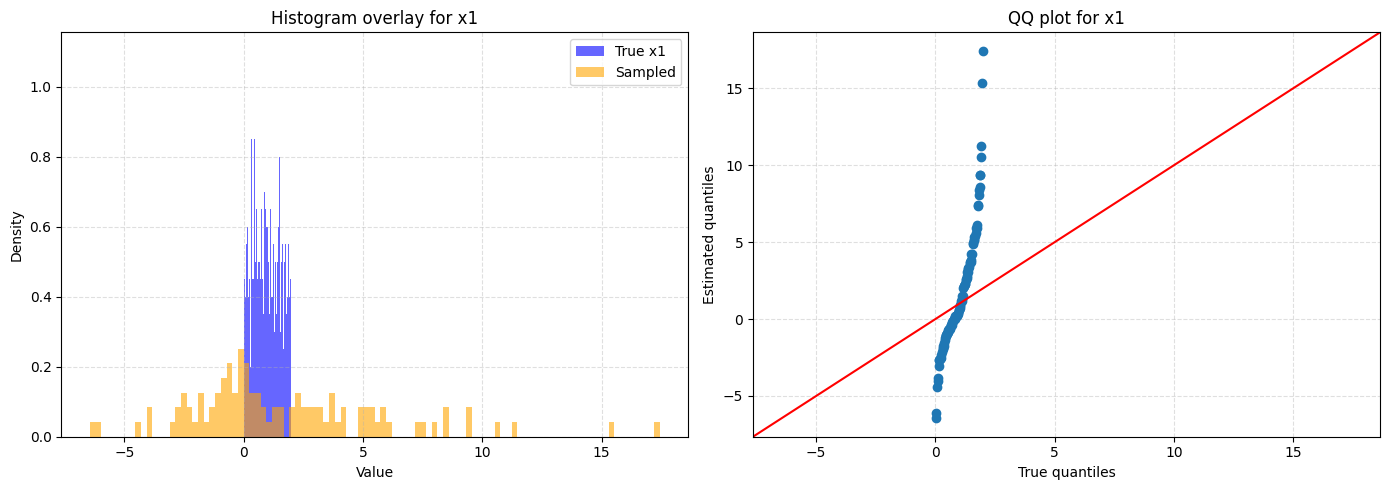

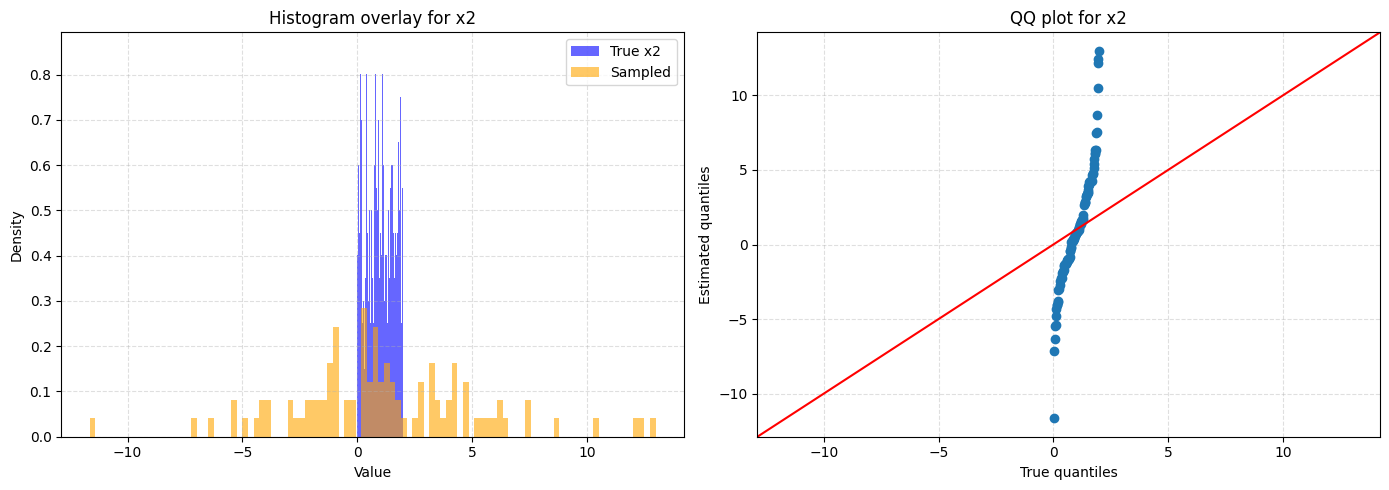

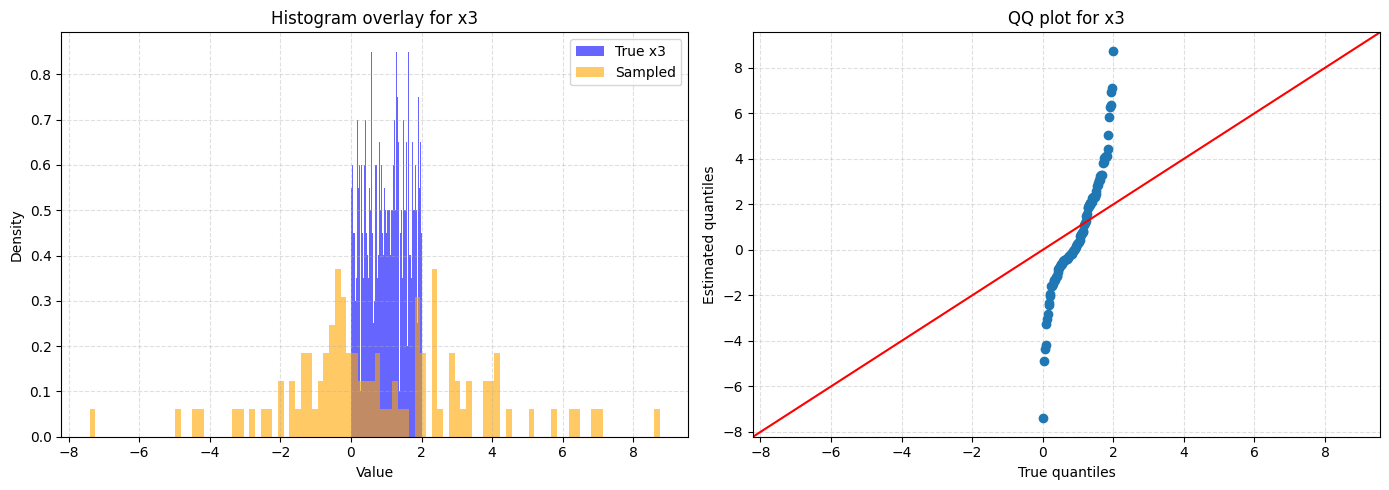

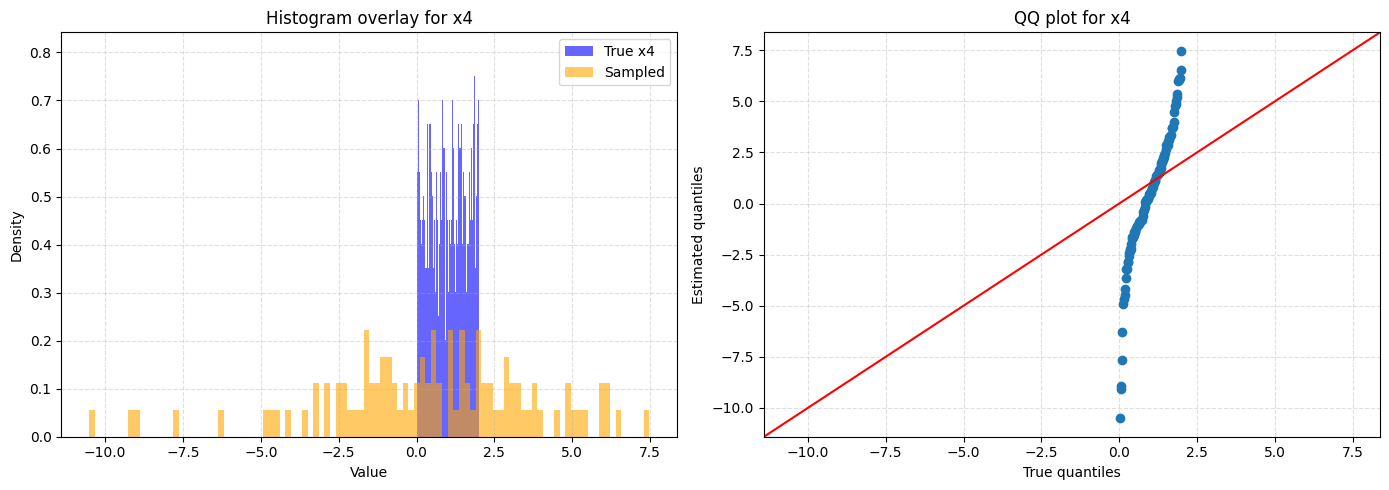

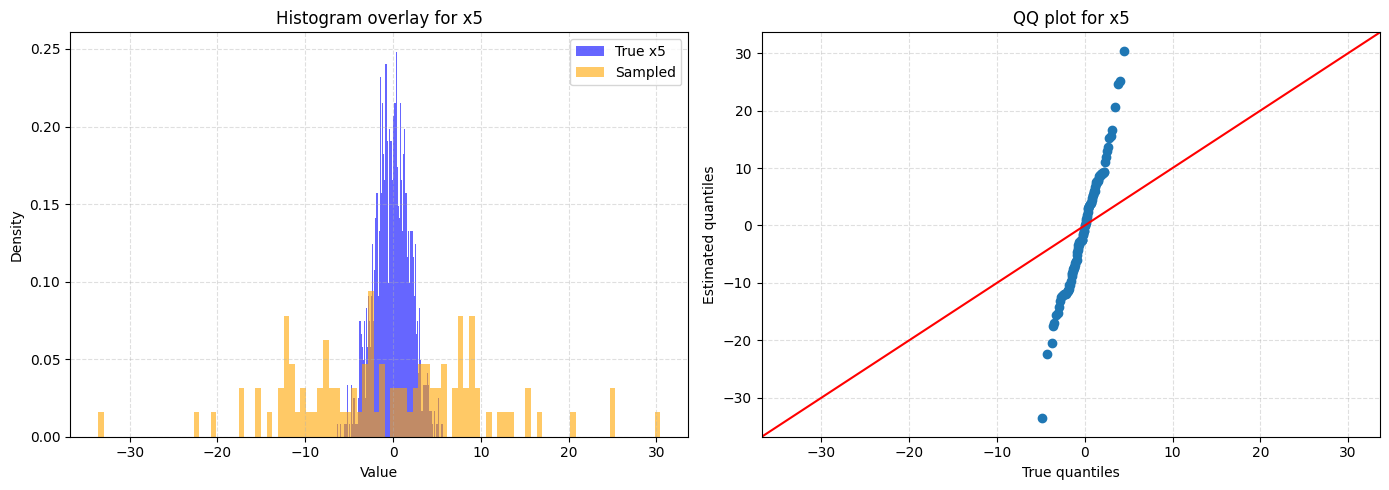

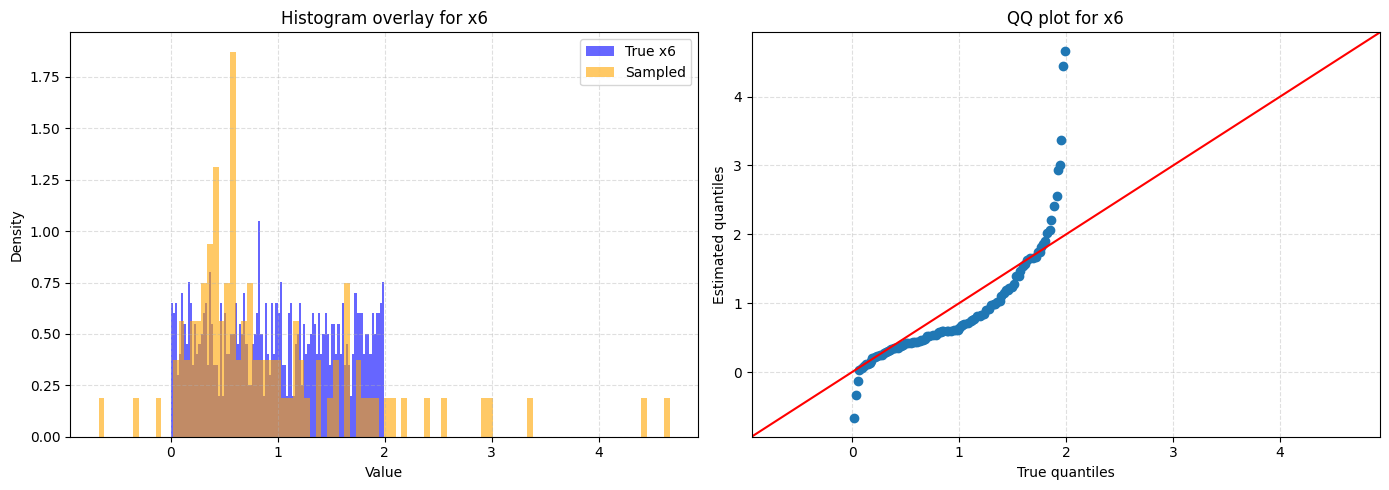

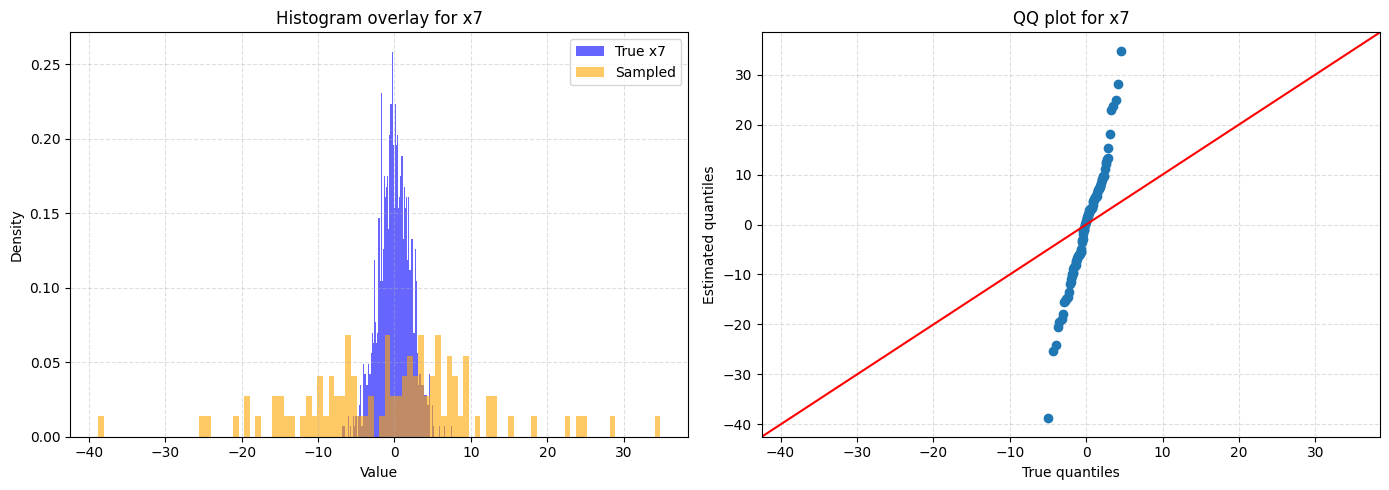

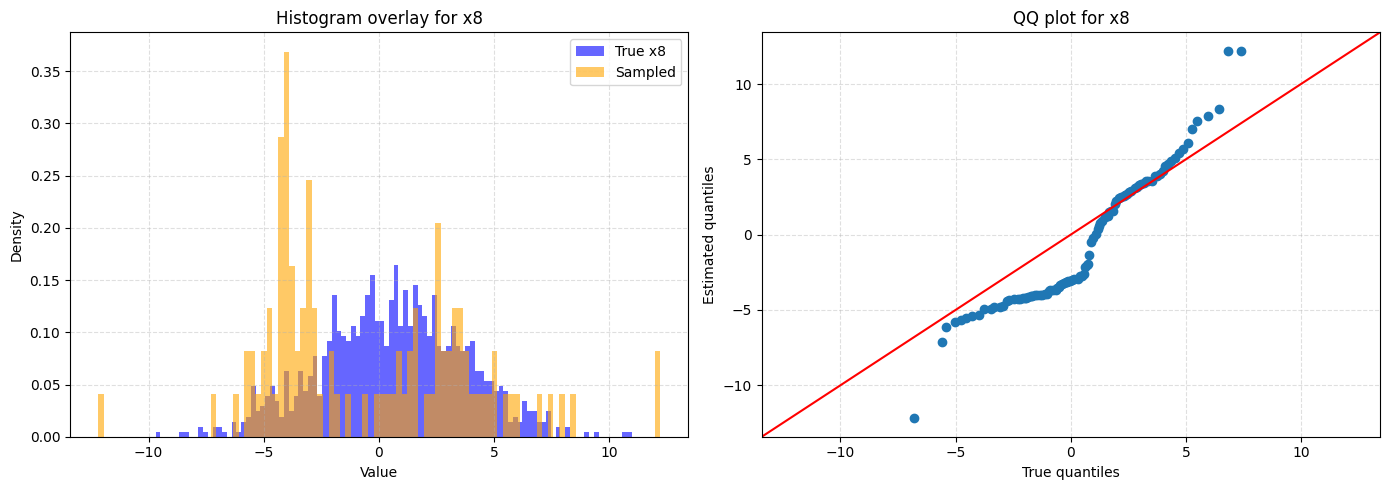

In [21]:
show_samples_vs_true(test_df,target_nodes,EXPERIMENT_DIR,rootfinder='chandrupatla')

## 7.4 Intervention

In [ ]:
def f(x):
    return -0.3*x  

intervention_df=dgp(10_000, doX=[-1.0, None, None], seed=-1)
sns.pairplot(intervention_df)
plt.suptitle("", y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
sample_full_dag_chandru(target_nodes,
                            EXPERIMENT_DIR,
                            device,
                            do_interventions={'x1':-1.0},
                            n= 10_000,
                            batch_size = 32,
                            delete_all_previously_sampled=True,
                            verbose=True)

In [ ]:
show_samples_vs_true(intervention_df,target_nodes,EXPERIMENT_DIR,rootfinder='chandrupatla')